In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/top-tech-companies-stock-price/List of SP 500 companies.csv
/kaggle/input/top-tech-companies-stock-price/Technology Sector List.csv
/kaggle/input/top-tech-companies-stock-price/Indices/IXIC.csv
/kaggle/input/top-tech-companies-stock-price/Indices/W5000.csv
/kaggle/input/top-tech-companies-stock-price/Indices/XLK.csv
/kaggle/input/top-tech-companies-stock-price/Indices/GSPC.csv
/kaggle/input/top-tech-companies-stock-price/Indices/DJI.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/UBER.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/TEL.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/STM.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/ANSS.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/CRWD.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/SAP.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/MSFT.csv
/kaggle/input/top-tech-

# Stock Price Prediction Using GRU (Gated Recurrent Unit)

Stock price prediction is a challenging task due to the noisy and non-stationary nature of financial data. However, Recurrent Neural Networks (RNNs) have shown promise in capturing temporal dependencies in sequential data. In this notebook, we use a **Gated Recurrent Unit (GRU)**, a type of RNN, for predicting stock prices.

## What is GRU?

GRU is an advanced variant of RNN that helps overcome the **vanishing gradient problem** typically seen in vanilla RNNs. It introduces a gating mechanism to control the flow of information and decides what to keep and discard in the sequence, making it well-suited for time series data like stock prices. Unlike LSTM, which has separate forget and input gates, GRU combines these into a single **update gate**, making it computationally more efficient while retaining similar accuracy.

### GRU Mechanism:
GRU consists of two main gates:
1. **Update Gate**: Determines how much of the past information needs to be passed to the future.
2. **Reset Gate**: Controls how much of the previous state to forget.

These mechanisms allow GRUs to capture long-term dependencies in sequences, making them ideal for tasks where future values depend on previous values, such as stock price prediction.

## Why Use GRU for Stock Price Prediction?

1. **Handling Sequential Data**: Stock prices are inherently sequential. GRU models can effectively capture patterns over time and are able to make predictions based on historical data.
   
2. **Long-Term Dependencies**: Unlike traditional models, GRU can retain important information over long periods without vanishing gradients, making it capable of learning from long-term trends in the market.

3. **Efficiency**: GRUs have fewer parameters compared to LSTMs, making them faster to train while maintaining similar predictive power.

## Dataset

We use historical stock price data, including key features like:
- **Date**
- **Close** prices

The target variable is the **Close** price, which we aim to predict using the past sequence of prices.

## Approach

1. **Data Preprocessing**: We perform standard preprocessing steps like normalization and handling missing values to make the data suitable for the GRU model.
   
2. **Model Architecture**: We build a GRU-based model using `TensorFlow/Keras`. The architecture includes:
   - GRU layers for sequence learning
   - Dense layers for output prediction
   - Dropout layers to avoid overfitting

3. **Evaluation**: We use **KFold cross-validation** to evaluate the model's performance and avoid overfitting on a single train-test split.


### 1. **Mathematics of GRU**
For a given time step $t$, the GRU cell operates as follows:

#### a. **Update Gate** $z_t$
The update gate $z_t$ controls how much of the hidden state from the previous time step $h_{t-1}$ should be carried over to the current time step.

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
$$

- $\sigma$ is the sigmoid function.
- $W_z$ is the weight matrix for the update gate.
- $h_{t-1}$ is the previous hidden state.
- $x_t$ is the input at time $t$.
- $b_z$ is the bias term for the update gate.

The update gate $z_t$ takes values between 0 and 1, deciding how much of the past information should be retained.

#### b. **Reset Gate** $r_t$
The reset gate $r_t$ determines how much of the past hidden state should be ignored when calculating the new candidate hidden state $\tilde{h}_t$.

$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
$$

- $W_r$ is the weight matrix for the reset gate.
- $b_r$ is the bias term for the reset gate.

#### c. **Candidate Hidden State** $\tilde{h}_t$
The candidate hidden state $\tilde{h}_t$ is computed based on the reset gate. If $r_t$ is close to 0, the previous hidden state is ignored. If $r_t$ is close to 1, more of the previous hidden state is considered.

$$
\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
$$

- $\odot$ represents the element-wise multiplication (Hadamard product).
- $\tanh$ is the hyperbolic tangent activation function.
- $W_h$ is the weight matrix for generating the candidate hidden state.
- $b_h$ is the bias term for the candidate hidden state.

#### d. **Final Hidden State** $h_t$
The final hidden state $h_t$ is a combination of the old hidden state $h_{t-1}$ and the candidate hidden state $\tilde{h}_t$, controlled by the update gate $z_t$.

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

This means:
- If $z_t$ is close to 1, the new candidate hidden state $\tilde{h}_t$ is used.
- If $z_t$ is close to 0, the previous hidden state $h_{t-1}$ is retained.

### 2. **Sigmoid and Tanh Functions**
- **Sigmoid function**: $\sigma(x) = \frac{1}{1 + e^{-x}}$. The sigmoid function squashes values between 0 and 1, which is why it’s used for the gates. It ensures that the update and reset gates are a proportion (between 0 and 1) of the previous and candidate hidden states.
  
- **Tanh function**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$. The tanh function squashes values between -1 and 1, which is why it’s used for the candidate hidden state. It allows both positive and negative contributions to the hidden state.

### 3. **How GRU Handles Long-Term Dependencies**
The update gate $z_t$ helps GRU manage long-term dependencies by allowing the network to pass the hidden state across many time steps with minimal updates when needed. This means:
- If the update gate is close to 1, it allows the network to retain memory over a long period.
- If the update gate is close to 0, it forces the network to forget the past and focus more on the new information.

### 4. **Advantages of GRU Over Vanilla RNN**
- **Gating Mechanism**: GRU uses gates to control the flow of information, which helps in learning long-term dependencies better than simple RNNs, which suffer from vanishing gradient problems.
- **Fewer Parameters than LSTM**: GRU has a simpler structure than LSTM (Long Short-Term Memory), which makes it faster to train, especially on smaller datasets, while still capturing dependencies effectively.

### 5. **GRU for Stock Price Prediction**
For stock price prediction, GRU can effectively model both short-term fluctuations and long-term trends by using its gating mechanism to remember or forget past prices. The GRU’s hidden state captures dependencies over time, which is important for forecasting.

- The **input** $x_t$ can be features like the previous day’s closing price, volume, and other stock-related metrics.
- The **output** at each time step could be the predicted closing price for the next day or a specific future horizon.

### Summary of GRU Workflow
1. **Input** the current time step data $x_t$ and the previous hidden state $h_{t-1}$.
2. Compute the **update gate** $z_t$ and **reset gate** $r_t$.
3. Use the reset gate to decide how much of the previous hidden state $h_{t-1}$ to forget.
4. Compute the **candidate hidden state** $\tilde{h}_t$ using the current input and the modified previous hidden state.
5. Use the update gate to compute the **final hidden state** $h_t$ as a combination of the previous hidden state and the candidate hidden state.
6. Pass $h_t$ to the next time step and repeat.

By the end of the sequence, GRU should have learned useful patterns to predict the next time step (e.g., stock price).

---


# GRU implemention on all 5 indices:
1. IXIC
2. W5000
3. XLK
4. GSPC
5. DJI

In [2]:
p1="/kaggle/input/top-tech-companies-stock-price/Indices/IXIC.csv"
p2="/kaggle/input/top-tech-companies-stock-price/Indices/W5000.csv"
p3="/kaggle/input/top-tech-companies-stock-price/Indices/XLK.csv"
p4="/kaggle/input/top-tech-companies-stock-price/Indices/GSPC.csv"
p5="/kaggle/input/top-tech-companies-stock-price/Indices/DJI.csv"
stock_index={}
stock_index[0] = "IXIC"
stock_index[1] = "W5000"
stock_index[2] = "XLK"
stock_index[3] = "GSPC"
stock_index[4] = "DJI"

paths = [p1,p2,p3,p4,p5]
df = ["dummy"]*5
time_series = []
for i in range(len(paths)):
    df[i] = pd.read_csv(paths[i])
    time_series.append(df[i]['Close'])
# time_series is a list of all 5 index as its element 

In [3]:
def build_gru_model(input_shape,num_neurons):
    model = Sequential()
    model.add(GRU(num_neurons, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

In [5]:
def fit_gru(hyperparameter_k,hyperparameter_neurons, df, df_ind):
    print(f"Dataframe {stock_index[df_ind]} is being loaded ....")
    print(f"Training for sequence length: {hyperparameter_k}")
    print(f"Training on num neurons: {hyperparameter_neurons}")

    close_prices = df.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(close_prices)

    sequence_length = hyperparameter_k  
    X, y = create_sequences(scaled_close, sequence_length)

    # Reshape X for GRU input
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train-test split (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=False)

    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"\nFold {fold + 1} training...")
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build and train the model
        model = build_gru_model((X_train_fold.shape[1], 1),hyperparameter_neurons)
        history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

        # Record the validation loss for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

        # Check if this is the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model  # Save the model with the best validation loss

    # Print all validation losses
    print("\nValidation losses for each fold:")
    for fold, loss in enumerate(val_losses):
        print(f"Fold {fold + 1}: Validation Loss = {loss}")

    print(f"\nBest validation loss: {best_val_loss}")

    # Evaluate on test set using the best model
    predicted_test = best_model.predict(X_test)

    # Inverse scaling to compare with original prices
    predicted_test = scaler.inverse_transform(predicted_test)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(predicted_test, y_test_actual)
    print(f"Mean Absolute Error is {mae}")

    # Plot the original vs predicted time series
    plt.figure(figsize=(10,6))
    plt.plot(y_test_actual, label="Actual Close Prices", color='blue')
    plt.plot(predicted_test, label="Predicted Close Prices", color='red')
    plt.title("Actual vs Predicted Close Prices")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()
    
    return (hyperparameter_k, hyperparameter_neurons,best_model,mae)


Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0149 - val_loss: 1.2563e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0811e-05 - val_loss: 1.2562e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6642e-05 - val_loss: 1.1775e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5682e-05 - val_loss: 1.1456e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6210e-05 - val_loss: 1.1425e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4679e-05 - val_loss: 1.0801e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4188e-05 - val_loss: 1.0515e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4012e-05 - val_loss: 1.0287e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1524e-05 - val_loss: 1.0235e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1179e-05 - val_loss: 1.0078e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.037

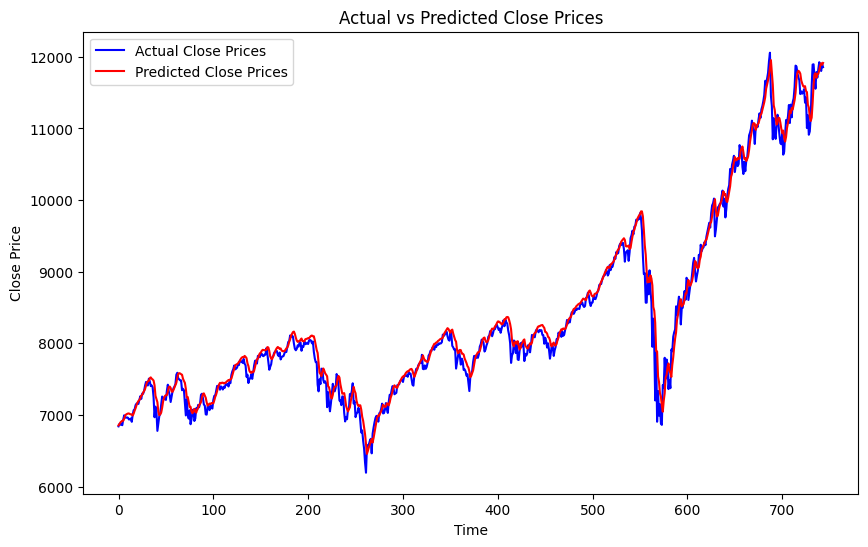

Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0062 - val_loss: 2.9864e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7648e-05 - val_loss: 1.1035e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1817e-05 - val_loss: 1.0486e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.2826e-05 - val_loss: 1.0274e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1316e-05 - val_loss: 1.0283e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1357e-05 - val_loss: 1.0579e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3235e-05 - val_loss: 1.0313e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9980e-05 - val_loss: 9.4697e-06
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0505e-05 - val_loss: 1.0102e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0301e-05 - val_loss: 1.5250e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.013

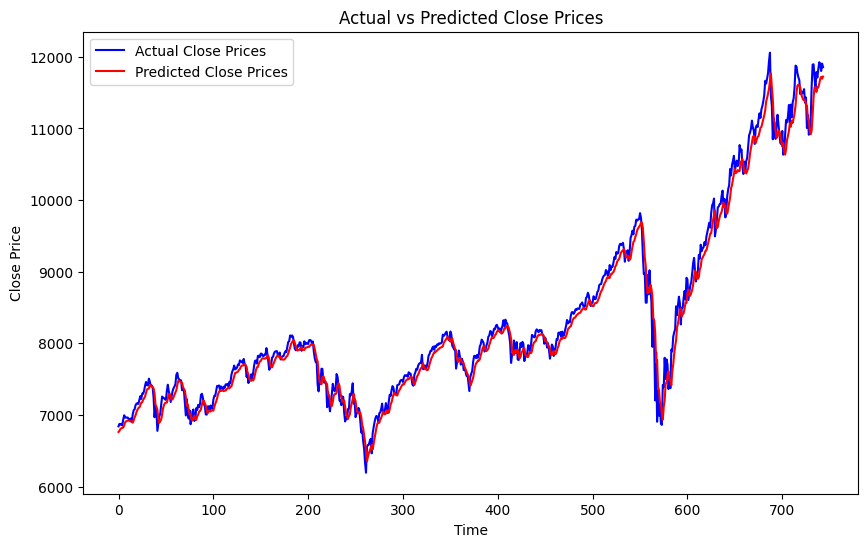

Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0113 - val_loss: 3.1351e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0235e-05 - val_loss: 1.1989e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8161e-05 - val_loss: 1.1759e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5458e-05 - val_loss: 1.3105e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5937e-05 - val_loss: 1.1114e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2812e-05 - val_loss: 1.0906e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5256e-05 - val_loss: 1.2096e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6626e-05 - val_loss: 1.1233e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1836e-05 - val_loss: 1.0581e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2629e-05 - val_loss: 1.1265e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.018

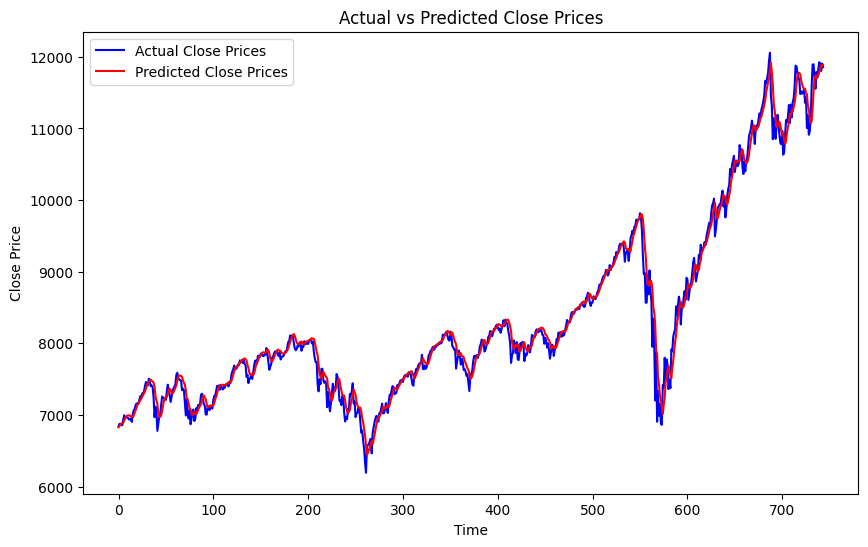

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0143 - val_loss: 2.8121e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0947e-04 - val_loss: 1.4146e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4218e-05 - val_loss: 1.1622e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4063e-05 - val_loss: 1.2232e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.6694e-05 - val_loss: 1.3500e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4507e-05 - val_loss: 1.3124e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.3054e-05 - val_loss: 1.4178e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1809e-05 - val_loss: 1.0382e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2072e-05 - val_loss: 1.0186e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.0386e-05 - val_loss: 1.1482e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.038

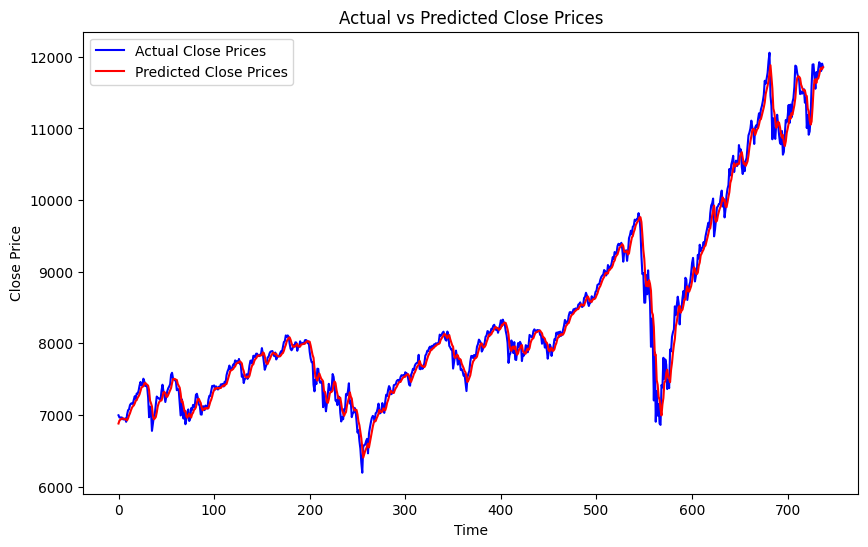

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0103 - val_loss: 2.5335e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0517e-05 - val_loss: 1.1070e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.2599e-05 - val_loss: 1.0865e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.2297e-05 - val_loss: 1.0632e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.0995e-05 - val_loss: 1.0468e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.1750e-05 - val_loss: 1.1782e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1766e-05 - val_loss: 1.0108e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1033e-05 - val_loss: 1.0060e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1466e-05 - val_loss: 1.2251e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1024e-05 - val_loss: 1.1852e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.007

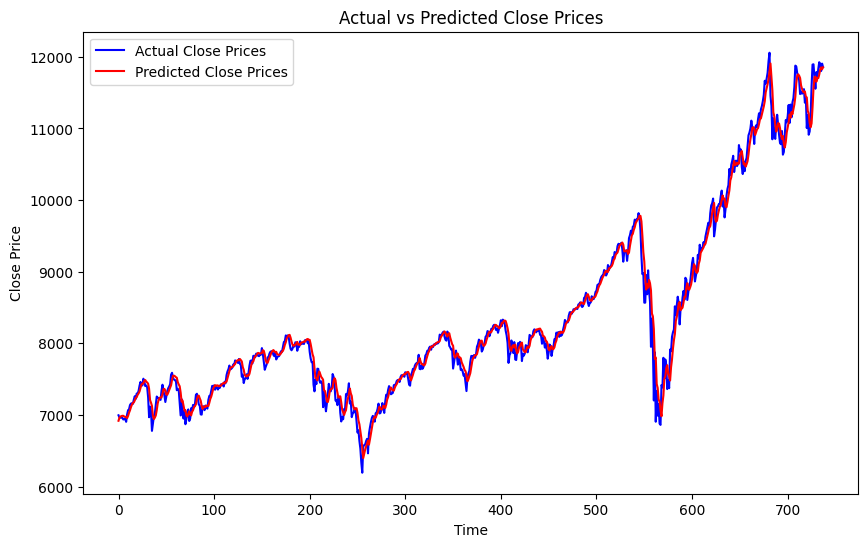

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0296 - val_loss: 2.6440e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.7113e-05 - val_loss: 1.4816e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.4380e-05 - val_loss: 1.5043e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.1107e-05 - val_loss: 1.5271e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.0721e-05 - val_loss: 1.3977e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.9902e-05 - val_loss: 2.1491e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.9892e-05 - val_loss: 1.3907e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.8763e-05 - val_loss: 1.3136e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.9134e-05 - val_loss: 1.2755e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.7598e-05 - val_loss: 1.2725e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.017

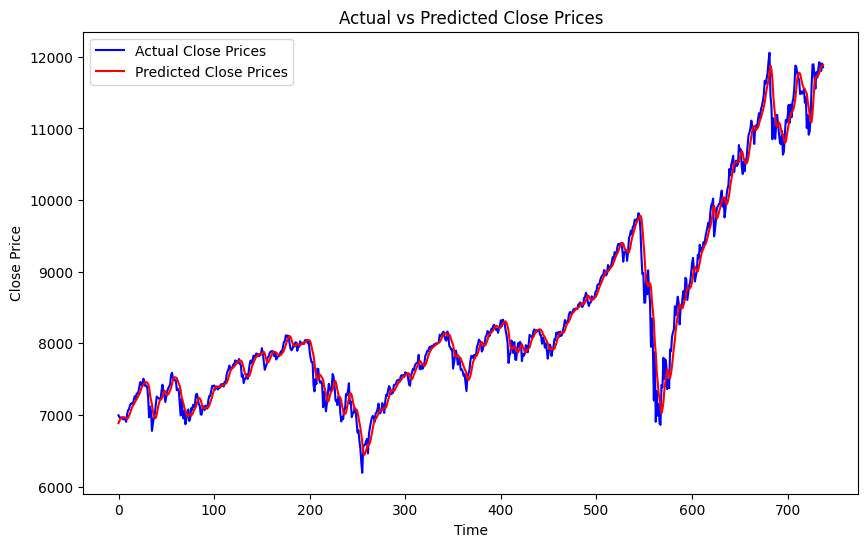

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0352 - val_loss: 0.0033
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011 - val_loss: 1.6446e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.2859e-05 - val_loss: 1.4799e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.9931e-05 - val_loss: 1.4727e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.8267e-05 - val_loss: 1.6811e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.1961e-05 - val_loss: 1.3724e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.7046e-05 - val_loss: 1.3566e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.6478e-05 - val_loss: 1.3830e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.6662e-05 - val_loss: 1.3628e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.4338e-05 - val_loss: 1.2443e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0195 - val_

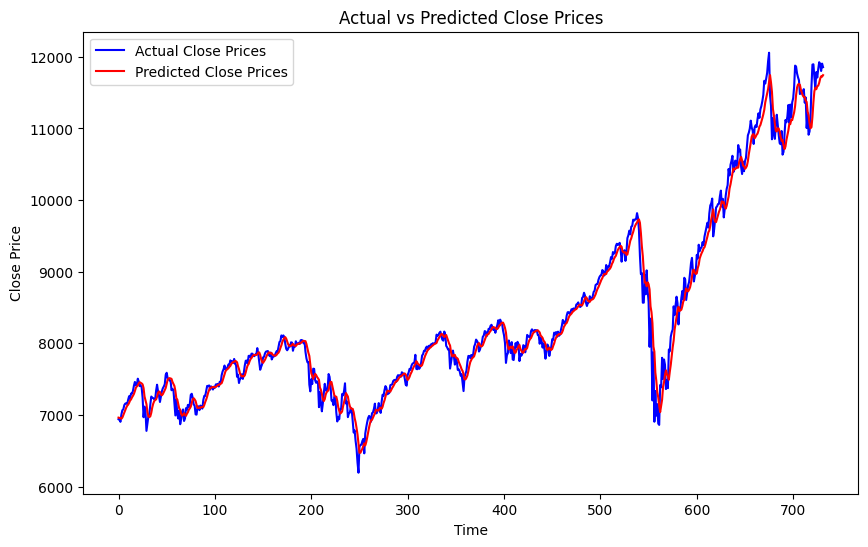

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0116 - val_loss: 1.3956e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.1395e-05 - val_loss: 1.3596e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.6159e-05 - val_loss: 1.2990e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8806e-05 - val_loss: 1.2724e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.5938e-05 - val_loss: 1.2585e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.3587e-05 - val_loss: 1.2236e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.4132e-05 - val_loss: 1.1820e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.2299e-05 - val_loss: 1.4896e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.6689e-05 - val_loss: 1.1457e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.2561e-05 - val_loss: 1.1089e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.031

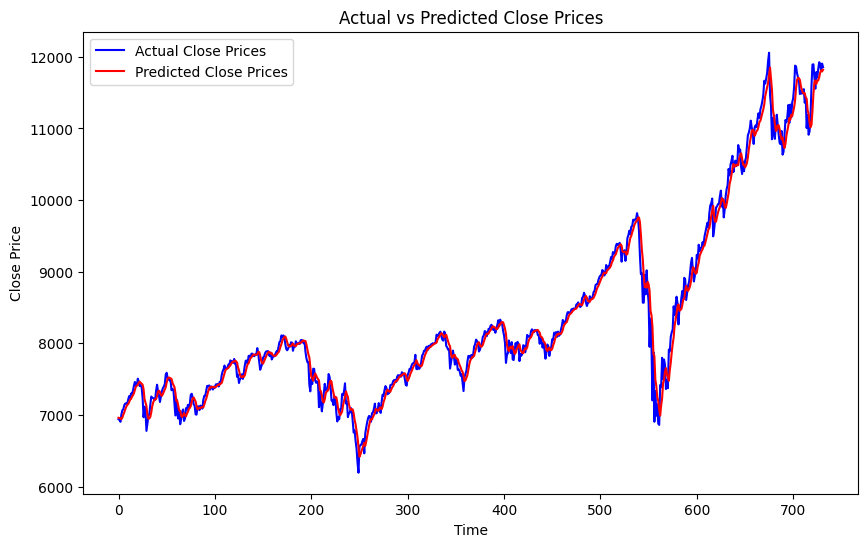

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0103 - val_loss: 7.0400e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3.5495e-05 - val_loss: 1.4825e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.9852e-05 - val_loss: 1.3466e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.3746e-05 - val_loss: 1.2874e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.4429e-05 - val_loss: 1.2550e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.6306e-05 - val_loss: 1.2185e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.2908e-05 - val_loss: 1.2149e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.5389e-05 - val_loss: 1.2755e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.1804e-05 - val_loss: 1.2717e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.5647e-05 - val_loss: 1.1257e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.020

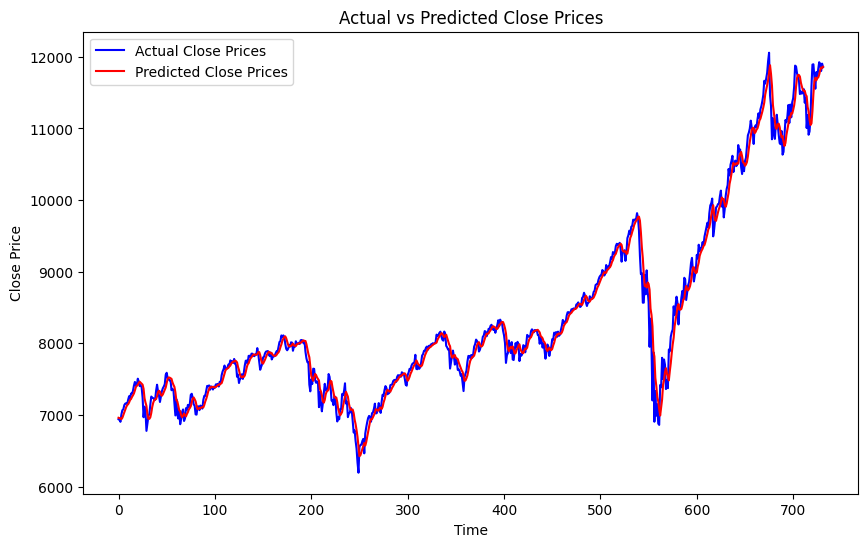

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0305 - val_loss: 0.0020
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 5.2870e-04 - val_loss: 3.1780e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 4.4950e-05 - val_loss: 2.5990e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 3.6884e-05 - val_loss: 2.3063e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 3.7269e-05 - val_loss: 2.1777e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.2682e-05 - val_loss: 2.0121e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.8681e-05 - val_loss: 2.0676e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.6714e-05 - val_loss: 2.1231e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.9008e-05 - val_loss: 1.8817e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.0172e-05 - val_loss: 1.8008e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0317 - 

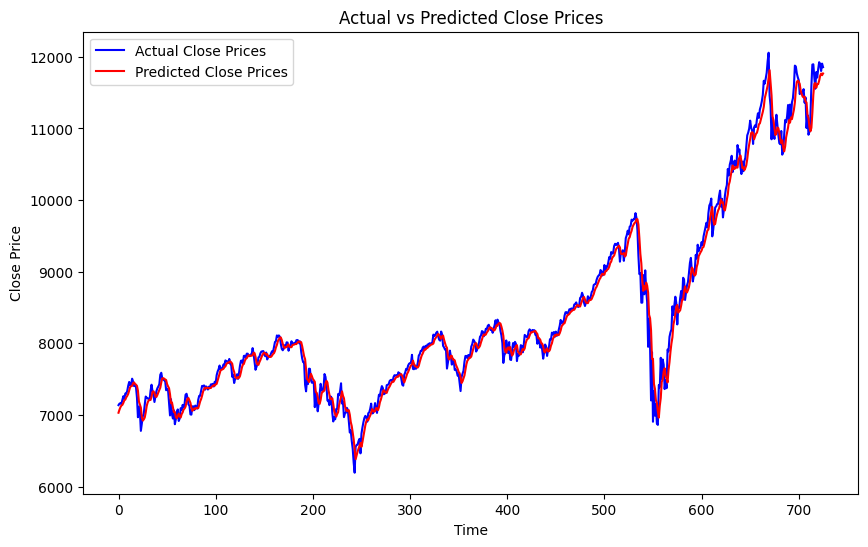

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0143 - val_loss: 1.8891e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 3.8983e-05 - val_loss: 1.9610e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.7786e-05 - val_loss: 1.8853e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.5481e-05 - val_loss: 1.7820e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.7727e-05 - val_loss: 1.9456e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 2.7733e-05 - val_loss: 1.6804e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.5849e-05 - val_loss: 1.9315e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.2811e-05 - val_loss: 1.6424e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.5659e-05 - val_loss: 1.7354e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.5547e-05 - val_loss: 1.5301e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.020

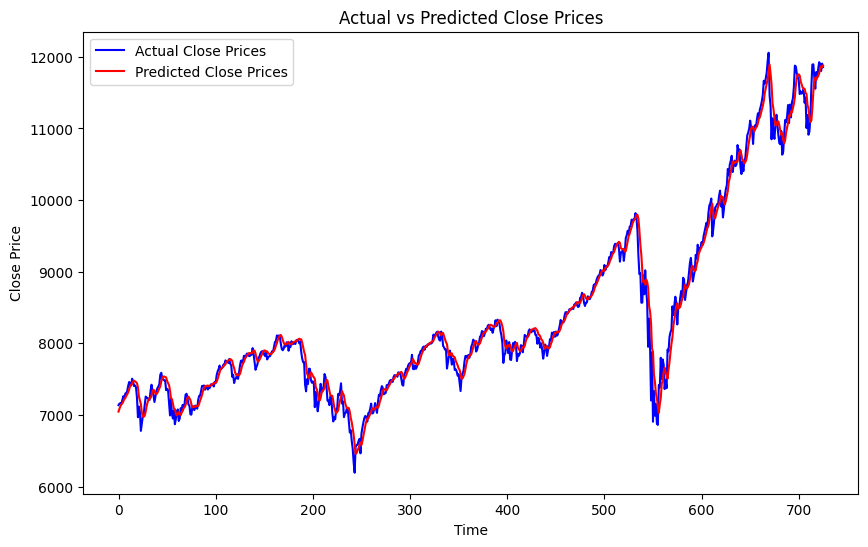

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0147 - val_loss: 3.4626e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.8298e-05 - val_loss: 2.0122e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.8293e-05 - val_loss: 1.8371e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2.7593e-05 - val_loss: 2.0106e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 2.5645e-05 - val_loss: 1.7816e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2.5891e-05 - val_loss: 1.8445e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2.5341e-05 - val_loss: 1.6697e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.5223e-05 - val_loss: 1.6955e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.6308e-05 - val_loss: 1.5857e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2.2658e-05 - val_loss: 1.8492e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.008

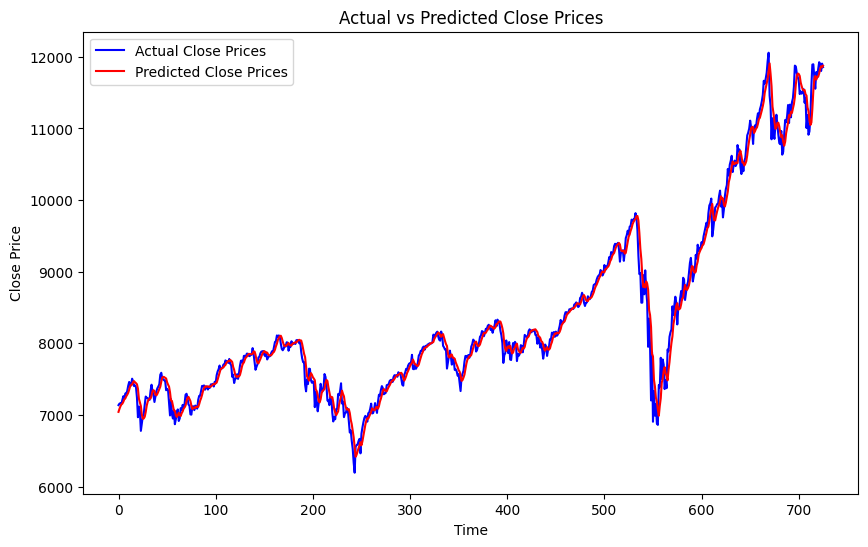







Dataframe W5000 is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0286 - val_loss: 6.4976e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8048e-04 - val_loss: 3.7290e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9170e-05 - val_loss: 3.4484e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3538e-05 - val_loss: 3.2309e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6637e-05 - val_loss: 3.1583e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2976e-05 - val_loss: 3.4919e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1233e-05 - val_loss: 3.0277e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5826e-05 - val_loss: 3.1173e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1975e-05 - val_loss: 2.8969e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0663e-05 - val_loss: 2.8159e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.030

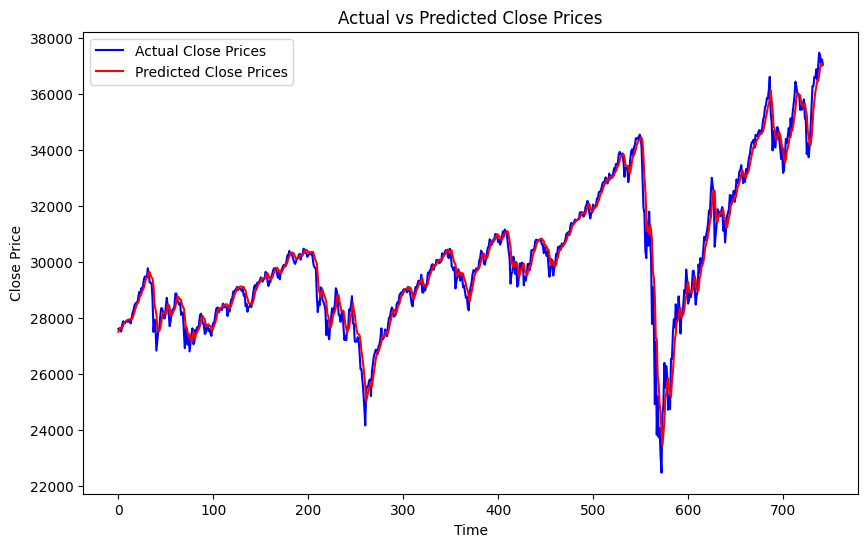

Dataframe W5000 is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0332 - val_loss: 4.7258e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.8865e-04 - val_loss: 3.9217e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8536e-05 - val_loss: 3.8480e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4140e-05 - val_loss: 3.9360e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.5979e-05 - val_loss: 3.9805e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7526e-05 - val_loss: 3.9573e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6313e-05 - val_loss: 3.4895e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.1842e-05 - val_loss: 3.8378e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.0899e-05 - val_loss: 3.8123e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6726e-05 - val_loss: 3.2607e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.051

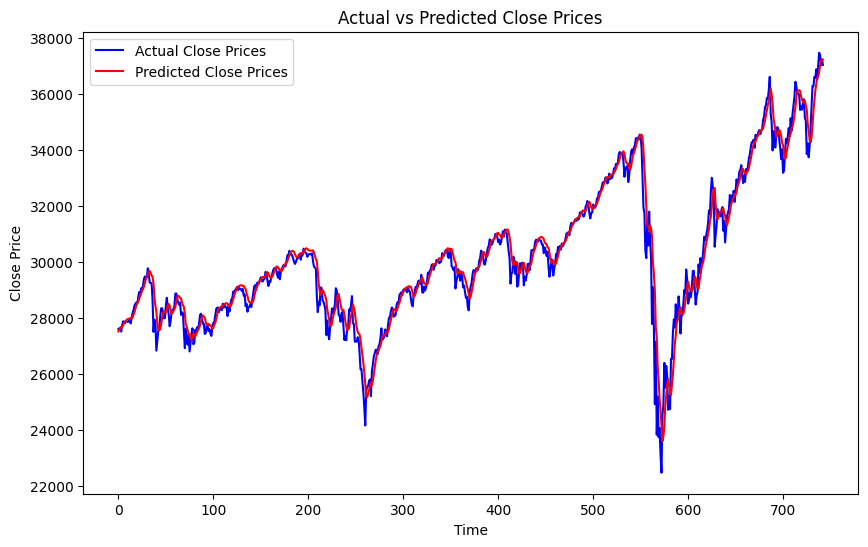

Dataframe W5000 is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0389 - val_loss: 2.6528e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4588e-04 - val_loss: 4.0311e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9656e-05 - val_loss: 3.9046e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1503e-05 - val_loss: 3.9254e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2116e-05 - val_loss: 3.9151e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8888e-05 - val_loss: 3.7439e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3132e-05 - val_loss: 3.7216e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2836e-05 - val_loss: 4.3564e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3847e-05 - val_loss: 3.8594e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7291e-05 - val_loss: 3.4159e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.013

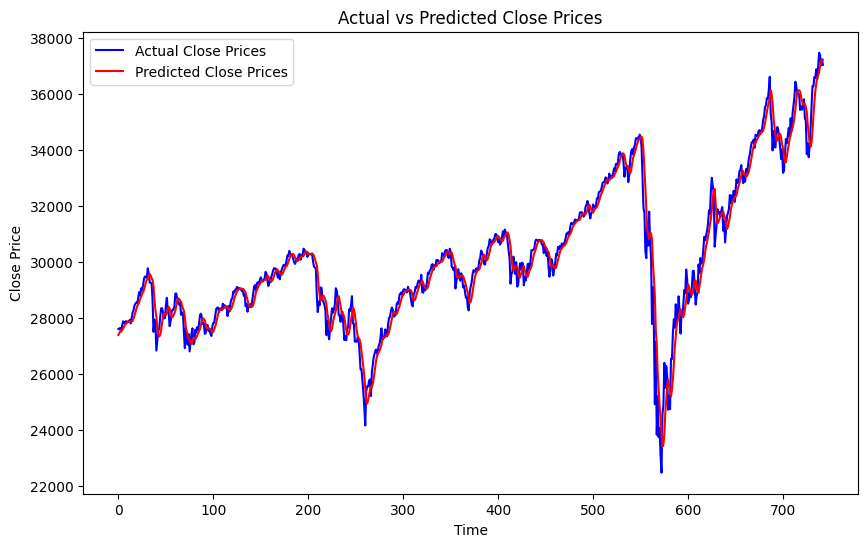

Dataframe W5000 is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0528 - val_loss: 0.0024
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0013 - val_loss: 7.1180e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.4670e-05 - val_loss: 4.1819e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.8395e-05 - val_loss: 3.9045e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.5818e-05 - val_loss: 4.1068e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.5511e-05 - val_loss: 3.7075e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.1323e-05 - val_loss: 3.8696e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.1019e-05 - val_loss: 3.5206e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.3249e-05 - val_loss: 3.3667e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.5707e-05 - val_loss: 3.2819e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0797 - val_

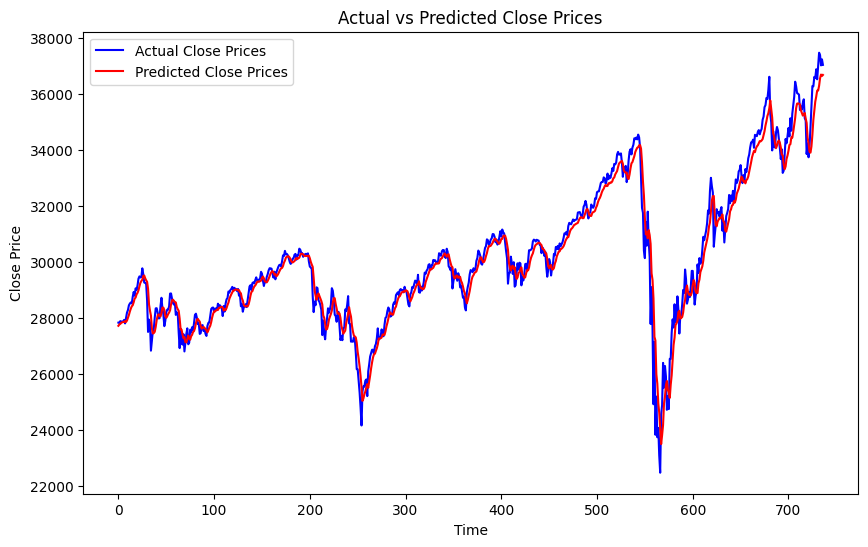

Dataframe W5000 is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0271 - val_loss: 1.6332e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.7590e-04 - val_loss: 3.6768e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.6511e-05 - val_loss: 3.5084e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.6549e-05 - val_loss: 3.4334e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.2253e-05 - val_loss: 3.6585e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.7366e-05 - val_loss: 3.2385e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.5786e-05 - val_loss: 3.1964e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.7663e-05 - val_loss: 3.2504e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.7671e-05 - val_loss: 2.9704e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.7061e-05 - val_loss: 3.2576e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.074

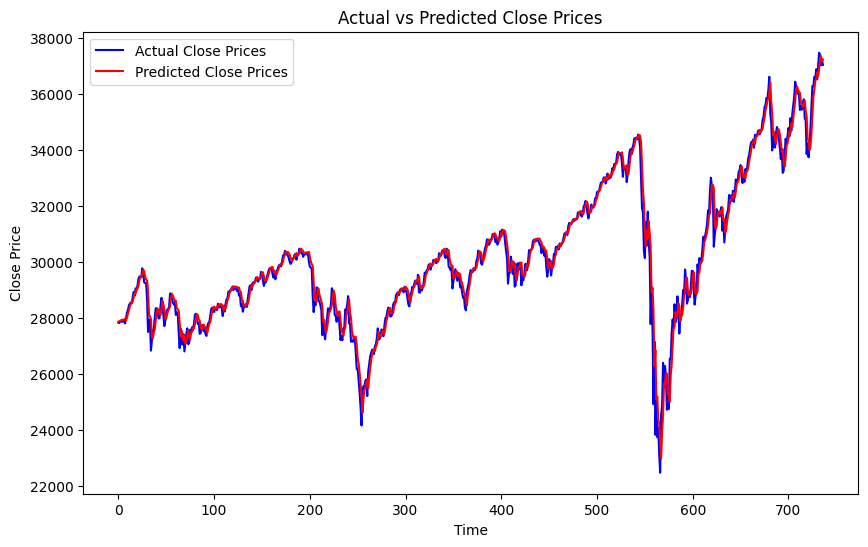

Dataframe W5000 is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0280 - val_loss: 2.4625e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.7355e-05 - val_loss: 3.8198e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.4193e-05 - val_loss: 3.6240e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.0567e-05 - val_loss: 3.6500e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.9224e-05 - val_loss: 3.4326e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.7153e-05 - val_loss: 3.7764e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.8870e-05 - val_loss: 3.3419e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.0589e-05 - val_loss: 3.3032e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.4674e-05 - val_loss: 3.1218e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.1417e-05 - val_loss: 3.2548e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.048

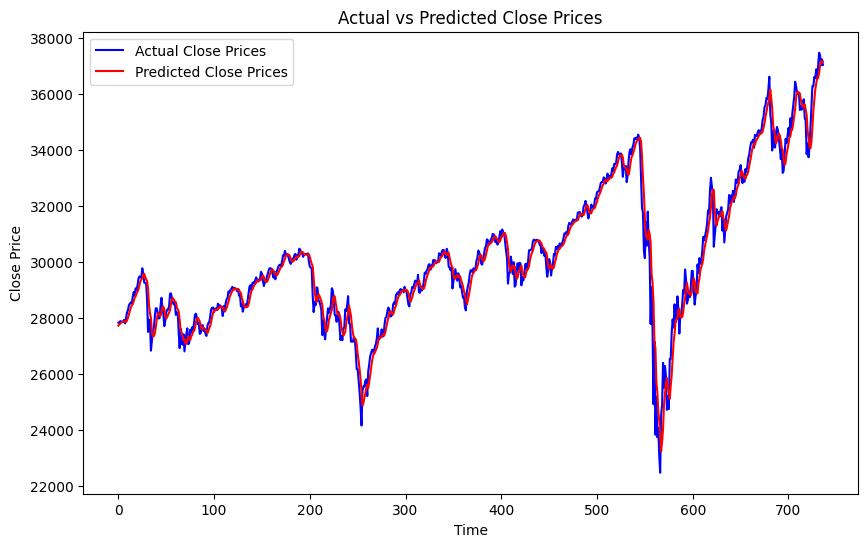

Dataframe W5000 is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0476 - val_loss: 0.0017
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0011 - val_loss: 4.6295e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.8928e-05 - val_loss: 4.1863e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 7.0946e-05 - val_loss: 4.0149e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.7763e-05 - val_loss: 3.7870e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.0390e-05 - val_loss: 3.7233e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.8110e-05 - val_loss: 3.7527e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.6651e-05 - val_loss: 3.4487e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 5.3480e-05 - val_loss: 3.3763e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.6020e-05 - val_loss: 3.4210e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0500 - val_

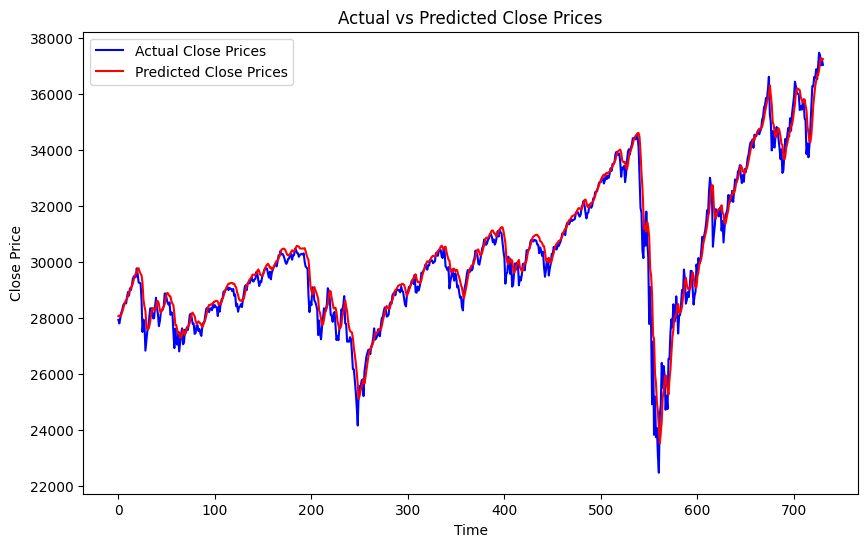

Dataframe W5000 is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0178 - val_loss: 1.1295e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.3460e-05 - val_loss: 3.6650e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.6785e-05 - val_loss: 3.5615e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.4723e-05 - val_loss: 3.9462e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.8250e-05 - val_loss: 3.5314e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.3559e-05 - val_loss: 3.5887e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.3514e-05 - val_loss: 3.5707e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.0741e-05 - val_loss: 3.8333e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.3837e-05 - val_loss: 3.1353e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.3376e-05 - val_loss: 3.1783e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.018

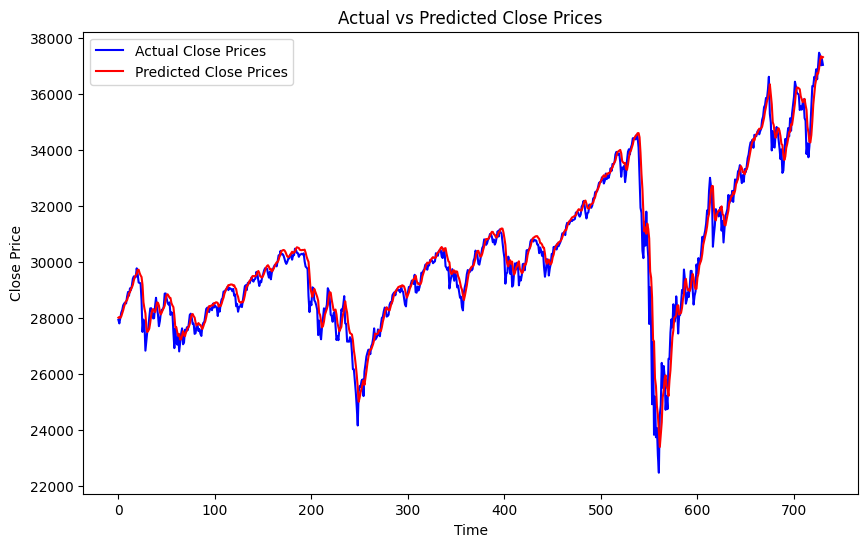

Dataframe W5000 is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0405 - val_loss: 2.2002e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.4550e-04 - val_loss: 4.5953e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.8411e-05 - val_loss: 4.5559e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.6710e-05 - val_loss: 4.3827e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 8.0436e-05 - val_loss: 4.9983e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 7.4134e-05 - val_loss: 4.6435e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.6693e-05 - val_loss: 4.0122e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.4243e-05 - val_loss: 4.2590e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.4029e-05 - val_loss: 4.1794e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.9195e-05 - val_loss: 3.9773e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.015

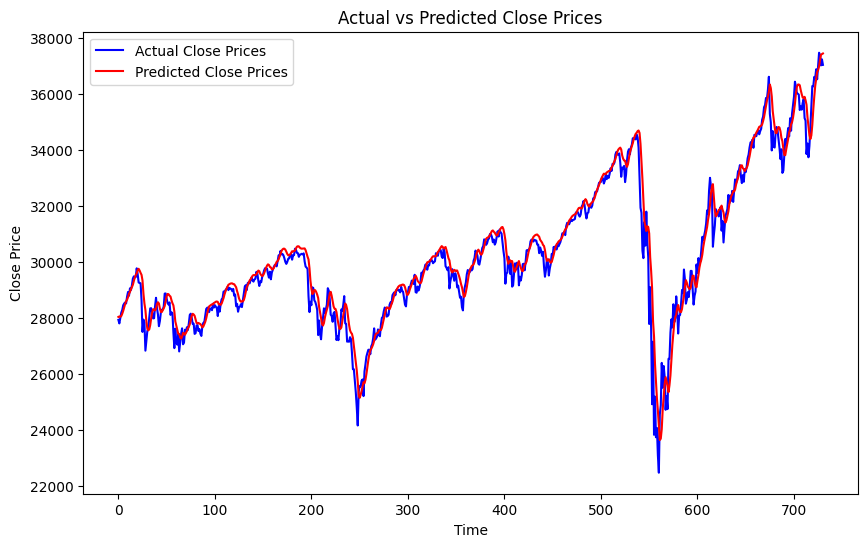

Dataframe W5000 is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0344 - val_loss: 0.0018
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0011 - val_loss: 5.0897e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.9646e-05 - val_loss: 4.7416e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.5854e-05 - val_loss: 4.6014e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.1895e-05 - val_loss: 4.6250e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.4553e-05 - val_loss: 4.4122e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.2679e-05 - val_loss: 4.4061e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.6686e-05 - val_loss: 4.2501e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.4009e-05 - val_loss: 4.3113e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.7872e-05 - val_loss: 4.2648e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0415 - val_

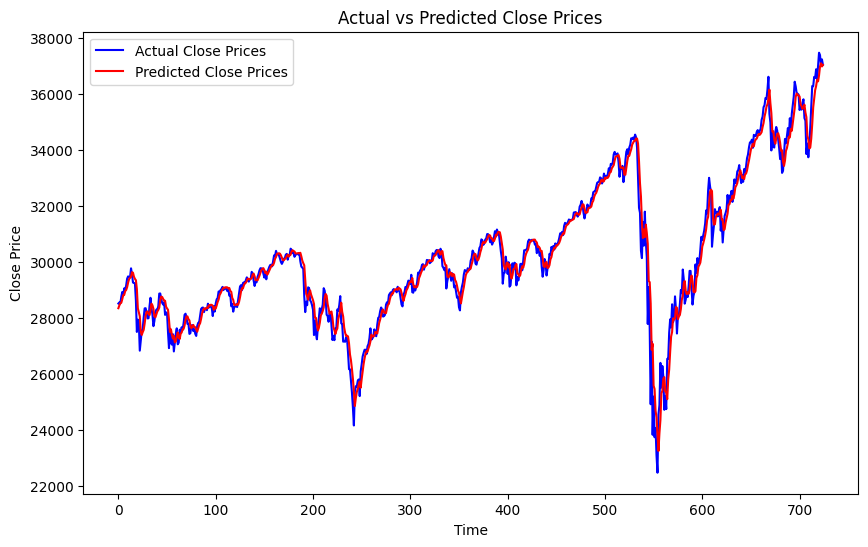

Dataframe W5000 is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0659 - val_loss: 0.0021
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0012 - val_loss: 8.8385e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.1765e-05 - val_loss: 7.0598e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 7.6437e-05 - val_loss: 6.8040e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.9471e-05 - val_loss: 6.5661e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.5215e-05 - val_loss: 6.3004e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.2401e-05 - val_loss: 6.5001e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.8615e-05 - val_loss: 5.9809e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 5.8576e-05 - val_loss: 5.7064e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.4952e-05 - val_loss: 5.5632e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0290 - val_

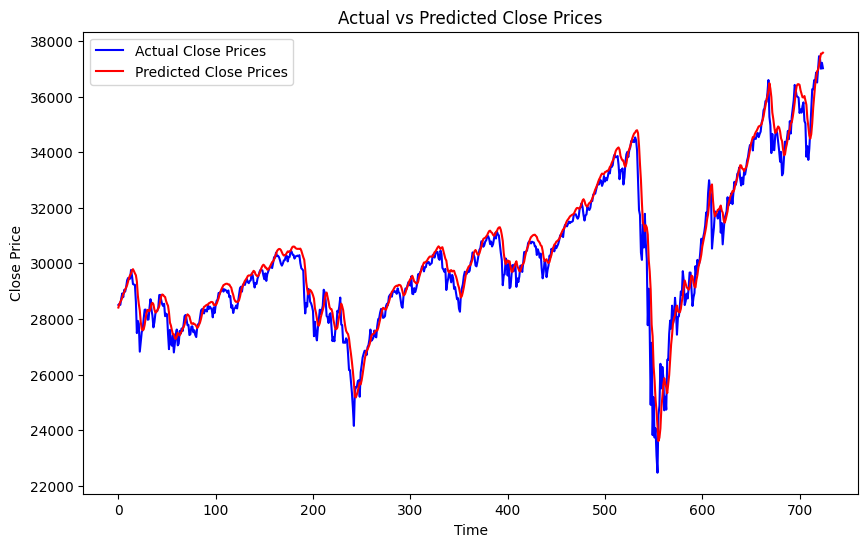

Dataframe W5000 is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0246 - val_loss: 2.6969e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 9.4660e-05 - val_loss: 5.5804e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 5.4474e-05 - val_loss: 5.3787e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.0225e-05 - val_loss: 5.4628e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 5.1201e-05 - val_loss: 5.5800e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.8278e-05 - val_loss: 5.1597e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.8854e-05 - val_loss: 4.8472e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.3258e-05 - val_loss: 4.7395e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.5263e-05 - val_loss: 4.6699e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.6651e-05 - val_loss: 4.9026e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.021

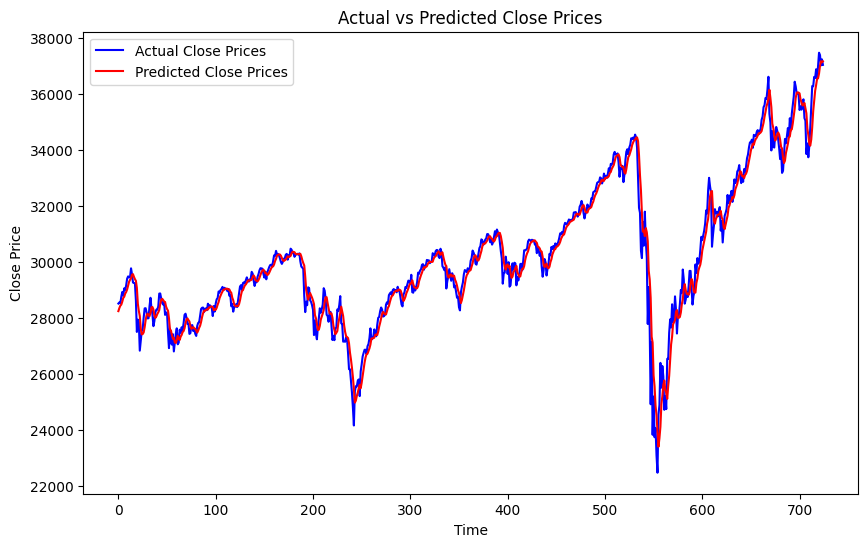







Dataframe XLK is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0041 - val_loss: 1.4169e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9845e-05 - val_loss: 9.5413e-06
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8831e-05 - val_loss: 9.3514e-06
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6181e-05 - val_loss: 9.9489e-06
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7266e-05 - val_loss: 9.8082e-06
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6264e-05 - val_loss: 8.9076e-06
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6106e-05 - val_loss: 8.5543e-06
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4292e-05 - val_loss: 8.2555e-06
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4325e-05 - val_loss: 7.9184e-06
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4345e-05 - val_loss: 8.8919e-06

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.007

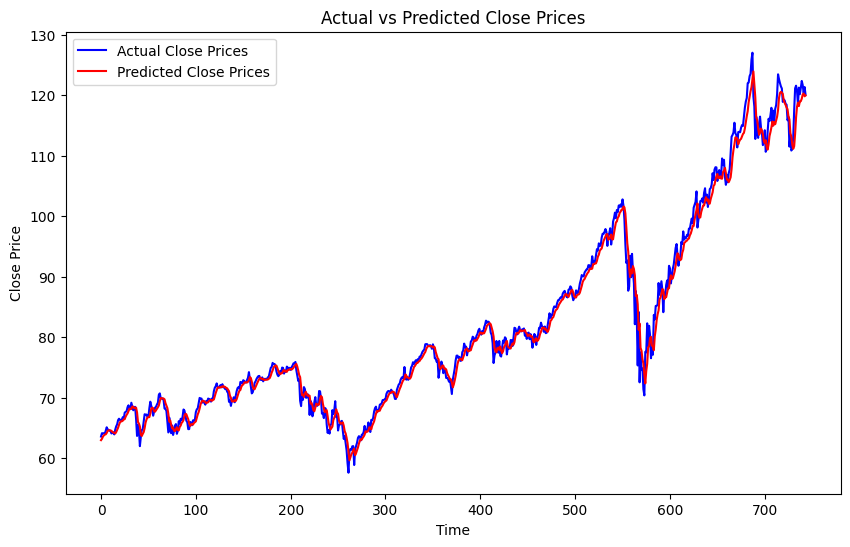

Dataframe XLK is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0090 - val_loss: 3.2681e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4569e-05 - val_loss: 1.0781e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0230e-05 - val_loss: 1.3059e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9349e-05 - val_loss: 1.0449e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9353e-05 - val_loss: 1.0285e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7480e-05 - val_loss: 1.0587e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7863e-05 - val_loss: 1.0354e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7967e-05 - val_loss: 1.3782e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8854e-05 - val_loss: 1.0453e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6217e-05 - val_loss: 9.0958e-06

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.006

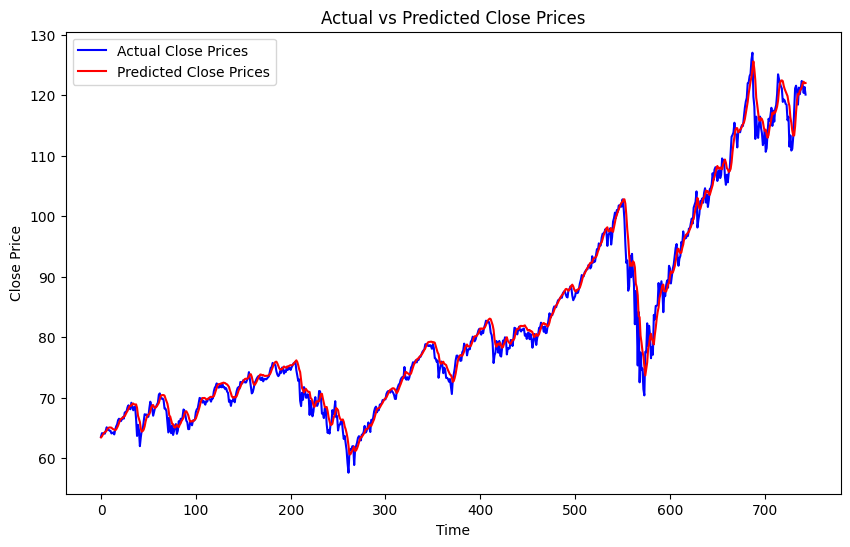

Dataframe XLK is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0073 - val_loss: 2.4522e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1181e-05 - val_loss: 1.0061e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7872e-05 - val_loss: 9.7926e-06
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6867e-05 - val_loss: 9.6118e-06
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7497e-05 - val_loss: 9.4461e-06
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7003e-05 - val_loss: 9.1777e-06
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7543e-05 - val_loss: 9.1105e-06
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5409e-05 - val_loss: 1.0161e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5964e-05 - val_loss: 8.7123e-06
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5951e-05 - val_loss: 9.2100e-06

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.007

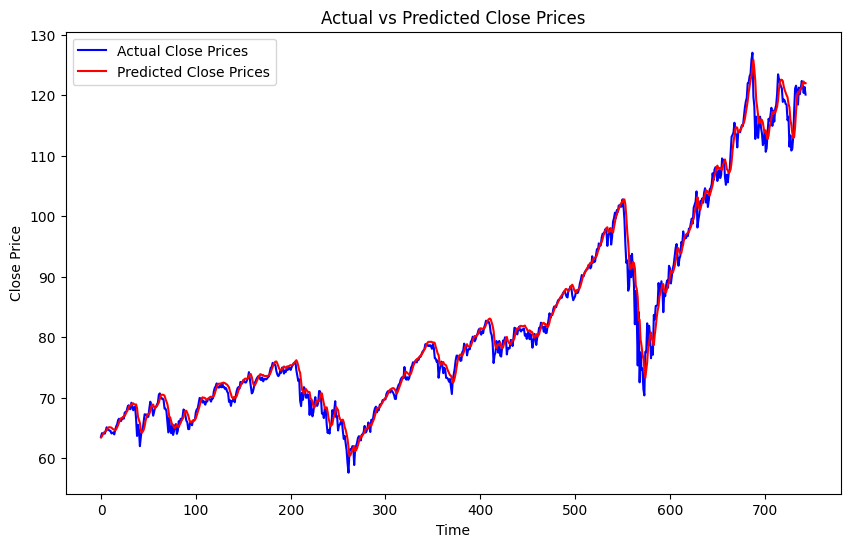

Dataframe XLK is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0107 - val_loss: 2.1965e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.6700e-05 - val_loss: 1.1601e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.9801e-05 - val_loss: 1.1609e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1000e-05 - val_loss: 1.0927e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9210e-05 - val_loss: 1.0731e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0350e-05 - val_loss: 1.0403e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.9121e-05 - val_loss: 1.1066e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.8152e-05 - val_loss: 1.1747e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.6872e-05 - val_loss: 9.6082e-06
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.7847e-05 - val_loss: 9.2522e-06

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.019

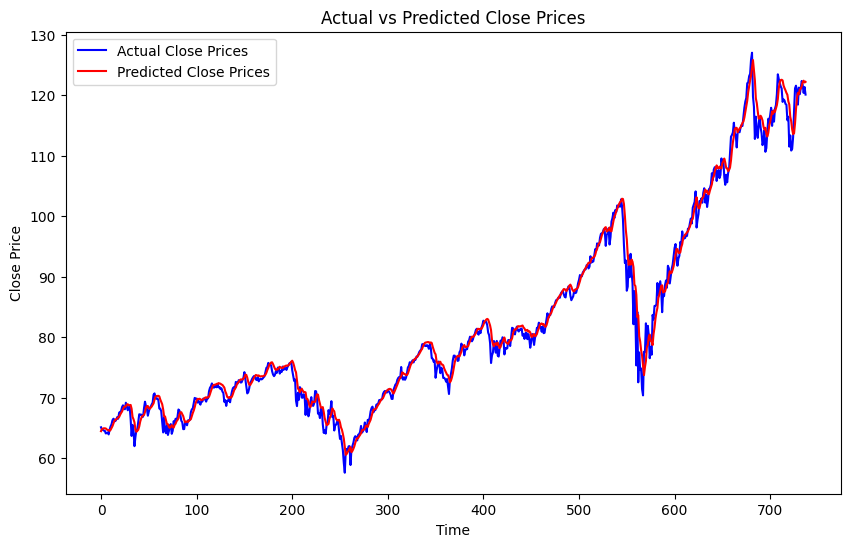

Dataframe XLK is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0055 - val_loss: 3.8923e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.4665e-05 - val_loss: 1.0069e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.6446e-05 - val_loss: 9.5206e-06
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.7618e-05 - val_loss: 9.2526e-06
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.7061e-05 - val_loss: 9.0849e-06
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6279e-05 - val_loss: 8.8131e-06
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.4808e-05 - val_loss: 8.6794e-06
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6605e-05 - val_loss: 8.6685e-06
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.5461e-05 - val_loss: 8.3813e-06
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.4181e-05 - val_loss: 9.8651e-06

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.010

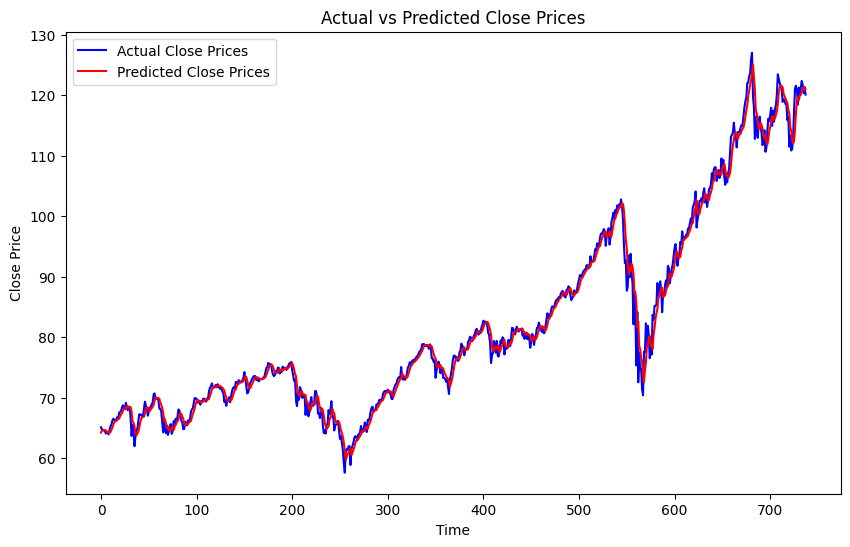

Dataframe XLK is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0187 - val_loss: 5.0939e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.8486e-05 - val_loss: 1.4407e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.3876e-05 - val_loss: 1.3982e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.2991e-05 - val_loss: 1.3287e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.2525e-05 - val_loss: 1.3007e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.3349e-05 - val_loss: 1.2758e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.2351e-05 - val_loss: 1.2305e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.1657e-05 - val_loss: 1.4426e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.1852e-05 - val_loss: 1.2870e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.4147e-05 - val_loss: 1.1516e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.003

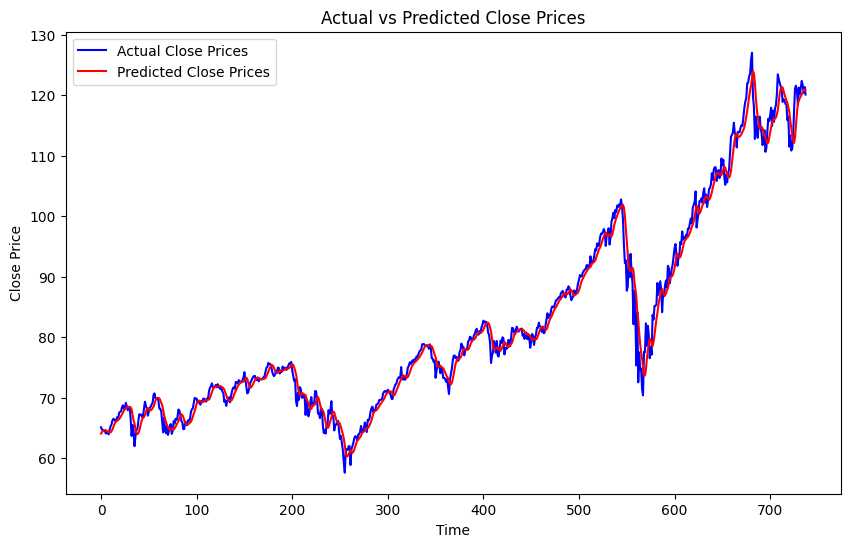

Dataframe XLK is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0149 - val_loss: 2.1436e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.4179e-05 - val_loss: 1.4705e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.6873e-05 - val_loss: 1.4581e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.7568e-05 - val_loss: 1.5275e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.5803e-05 - val_loss: 1.3540e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.3004e-05 - val_loss: 1.3230e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.1510e-05 - val_loss: 1.3535e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.2054e-05 - val_loss: 1.5888e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.1778e-05 - val_loss: 1.4240e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.2776e-05 - val_loss: 1.2132e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.005

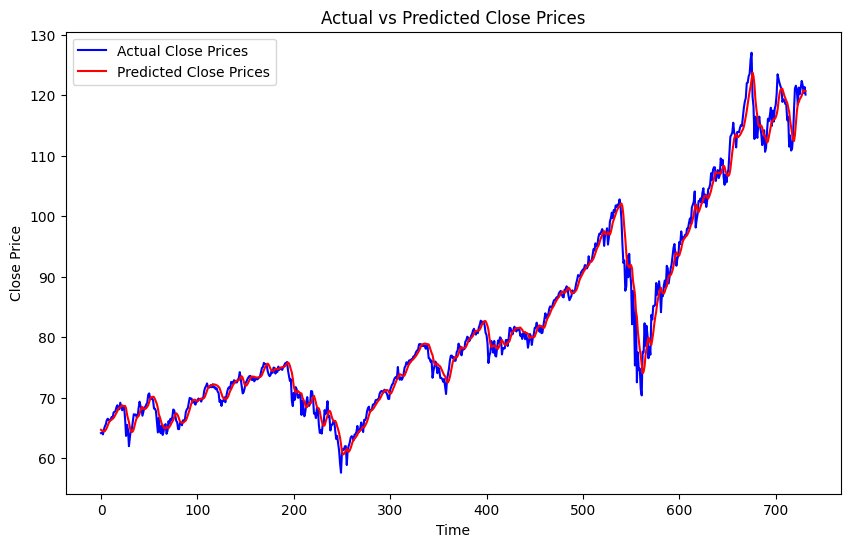

Dataframe XLK is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0057 - val_loss: 3.5754e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.4783e-05 - val_loss: 1.0469e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.7118e-05 - val_loss: 1.0152e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.6568e-05 - val_loss: 9.8381e-06
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5954e-05 - val_loss: 9.9728e-06
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.6152e-05 - val_loss: 9.5741e-06
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.6760e-05 - val_loss: 1.1170e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5863e-05 - val_loss: 9.0837e-06
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.5791e-05 - val_loss: 8.9367e-06
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5073e-05 - val_loss: 8.8028e-06

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.007

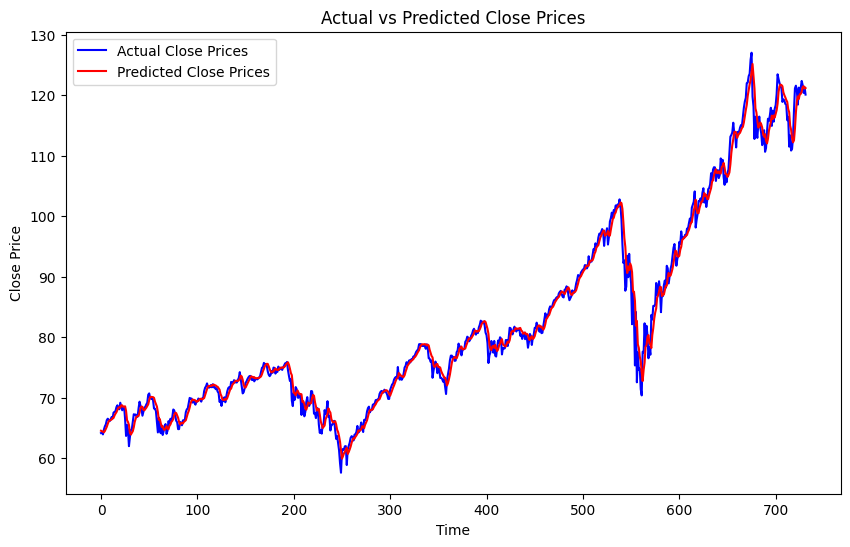

Dataframe XLK is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0143 - val_loss: 7.8973e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.4651e-05 - val_loss: 1.6125e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.3711e-05 - val_loss: 1.3730e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.2275e-05 - val_loss: 1.4808e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.2364e-05 - val_loss: 1.3361e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.2934e-05 - val_loss: 1.2887e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.1477e-05 - val_loss: 1.7347e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.5083e-05 - val_loss: 1.2278e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.1242e-05 - val_loss: 1.1999e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.9518e-05 - val_loss: 1.2343e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.006

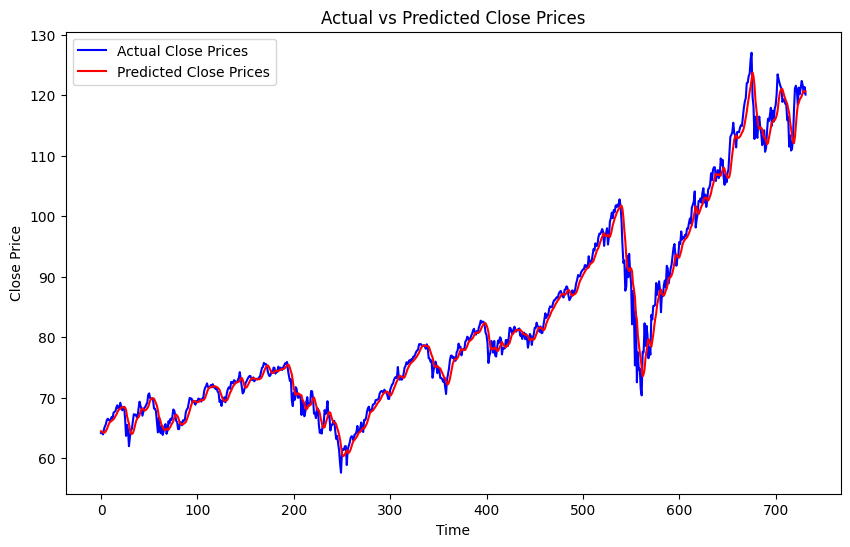

Dataframe XLK is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0108 - val_loss: 2.3620e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 7.8138e-05 - val_loss: 1.6599e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.8346e-05 - val_loss: 1.4491e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.7976e-05 - val_loss: 1.6220e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.7215e-05 - val_loss: 1.3870e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.6969e-05 - val_loss: 1.3810e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.7377e-05 - val_loss: 1.3159e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.6388e-05 - val_loss: 1.4834e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.5257e-05 - val_loss: 1.2458e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.5558e-05 - val_loss: 1.3026e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.021

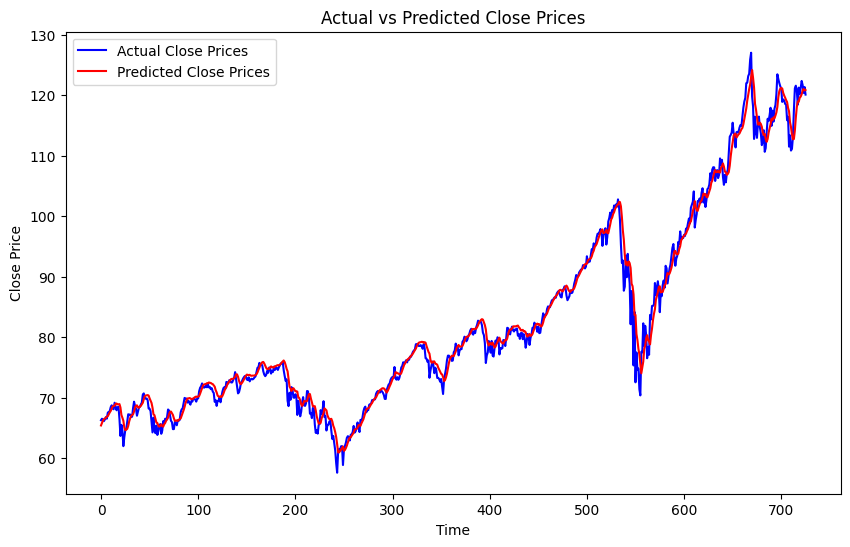

Dataframe XLK is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0124 - val_loss: 3.5640e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.0287e-05 - val_loss: 1.8546e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.2533e-05 - val_loss: 1.6818e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2.0264e-05 - val_loss: 1.6861e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.9693e-05 - val_loss: 1.7119e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.9239e-05 - val_loss: 1.5845e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.9936e-05 - val_loss: 1.6784e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.8885e-05 - val_loss: 1.4763e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.8777e-05 - val_loss: 1.4542e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.9733e-05 - val_loss: 1.6693e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.011

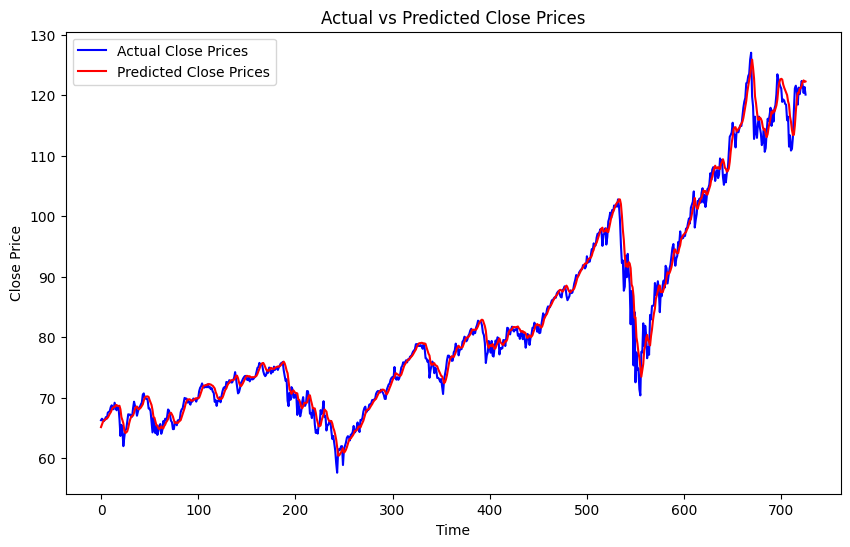

Dataframe XLK is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0091 - val_loss: 5.6778e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2.7173e-05 - val_loss: 1.7129e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.8894e-05 - val_loss: 1.6323e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.8824e-05 - val_loss: 1.6863e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1.8622e-05 - val_loss: 1.4656e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1.8274e-05 - val_loss: 1.5594e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1.8546e-05 - val_loss: 1.4525e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.7369e-05 - val_loss: 1.3620e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.5823e-05 - val_loss: 1.4302e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 1.6256e-05 - val_loss: 1.3077e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.006

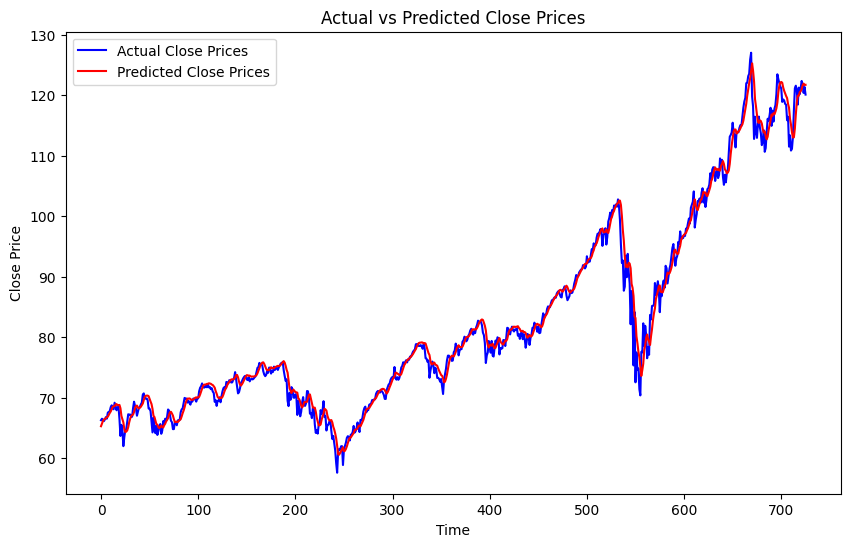







Dataframe GSPC is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0617 - val_loss: 0.0026
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - val_loss: 6.9214e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.8049e-05 - val_loss: 4.7506e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9047e-05 - val_loss: 5.1756e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4797e-05 - val_loss: 4.9663e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5976e-05 - val_loss: 3.9946e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7513e-05 - val_loss: 3.6129e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8354e-05 - val_loss: 3.6766e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5602e-05 - val_loss: 3.4630e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5636e-05 - val_loss: 3.6764e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0671 - val_

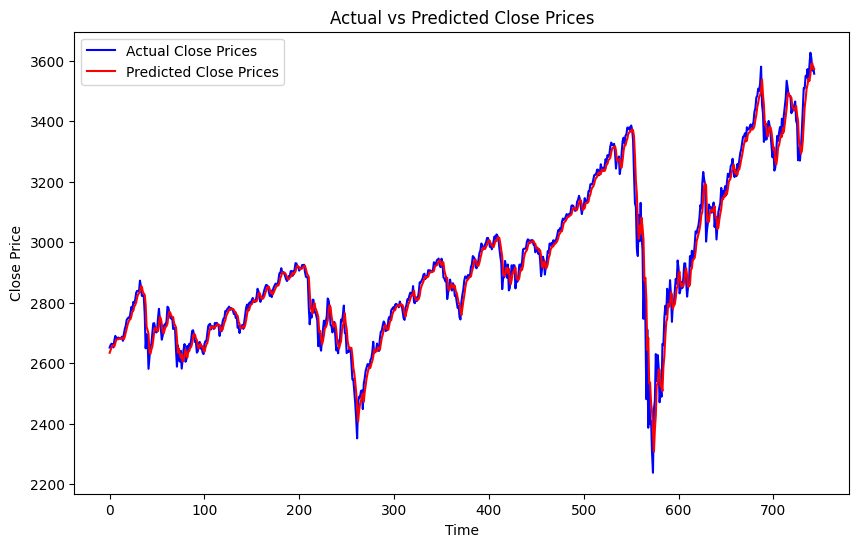

Dataframe GSPC is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0764 - val_loss: 0.0013
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2160e-04 - val_loss: 5.6465e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0684e-04 - val_loss: 5.1072e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.8162e-05 - val_loss: 6.0065e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5814e-05 - val_loss: 5.5060e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0644e-05 - val_loss: 4.3638e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0754e-05 - val_loss: 4.8466e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6764e-05 - val_loss: 4.1531e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7205e-05 - val_loss: 4.7288e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3647e-05 - val_loss: 4.4664e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0338 - 

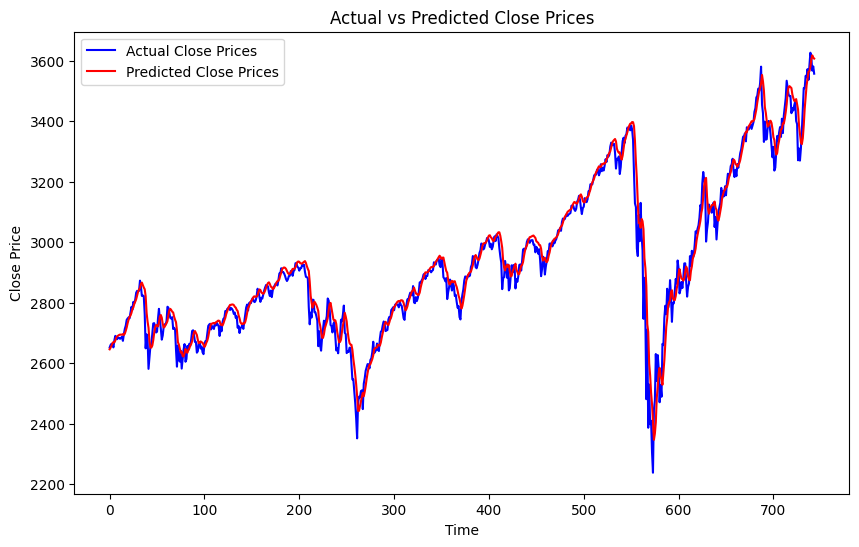

Dataframe GSPC is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0330 - val_loss: 1.7541e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.7889e-05 - val_loss: 4.0266e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4198e-05 - val_loss: 4.1438e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7471e-05 - val_loss: 3.6964e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7136e-05 - val_loss: 3.6872e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6699e-05 - val_loss: 3.5415e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9902e-05 - val_loss: 3.4789e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4026e-05 - val_loss: 3.5046e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3032e-05 - val_loss: 3.3482e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0479e-05 - val_loss: 3.4693e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.045

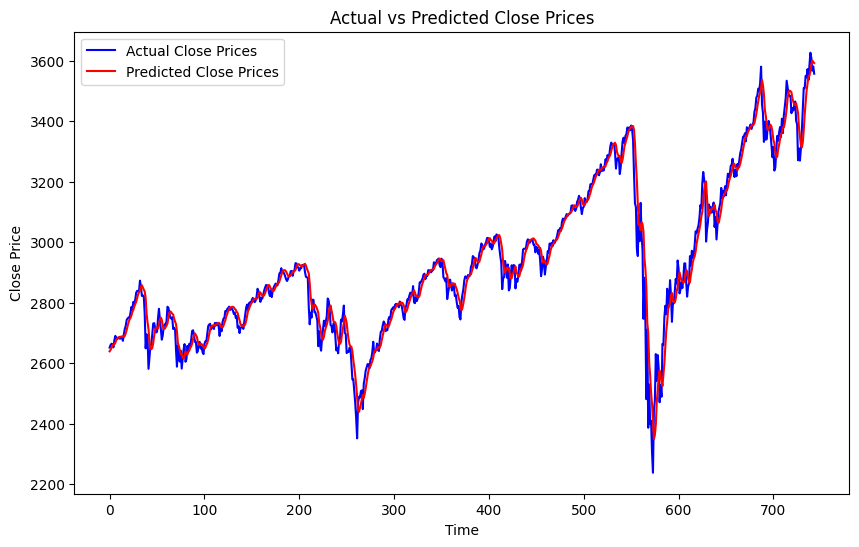

Dataframe GSPC is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0481 - val_loss: 0.0017
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014 - val_loss: 5.7349e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.1359e-05 - val_loss: 4.1859e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.1100e-05 - val_loss: 3.9547e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.2281e-05 - val_loss: 3.6325e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.9028e-05 - val_loss: 3.4134e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.5791e-05 - val_loss: 3.4073e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.5177e-05 - val_loss: 3.4734e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.9308e-05 - val_loss: 3.2643e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.6161e-05 - val_loss: 3.1302e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0728 - val_

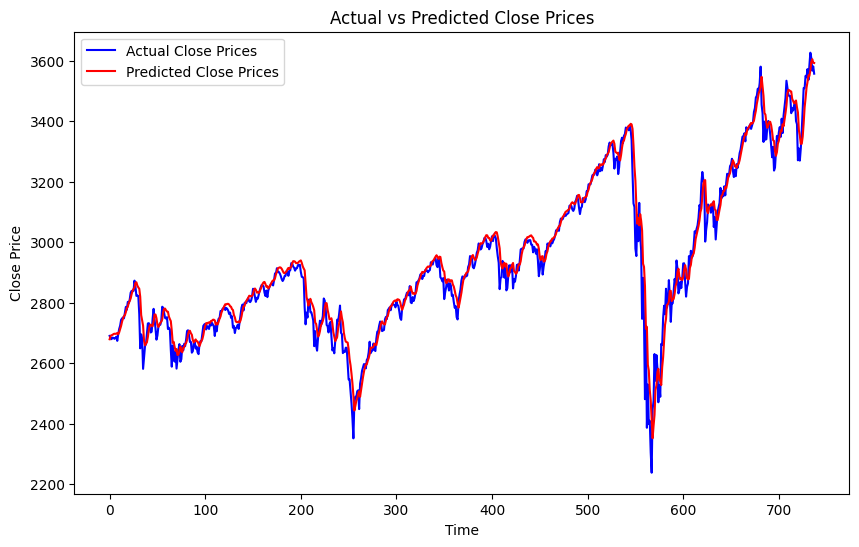

Dataframe GSPC is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0315 - val_loss: 1.1158e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2351e-04 - val_loss: 3.8656e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.5438e-05 - val_loss: 3.9501e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.6943e-05 - val_loss: 3.6478e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.5344e-05 - val_loss: 3.5520e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.5826e-05 - val_loss: 3.5131e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.9983e-05 - val_loss: 3.4046e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.1914e-05 - val_loss: 3.3083e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.0053e-05 - val_loss: 3.2206e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.4487e-05 - val_loss: 3.1539e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.032

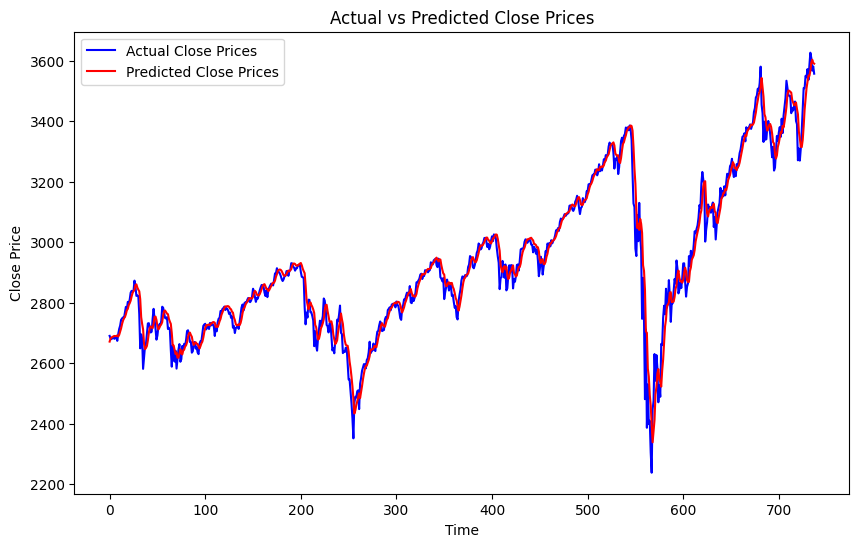

Dataframe GSPC is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0448 - val_loss: 3.5483e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.1745e-04 - val_loss: 4.6246e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.1020e-05 - val_loss: 4.3494e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.7638e-05 - val_loss: 4.1954e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.1617e-05 - val_loss: 4.0219e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.3658e-05 - val_loss: 3.9406e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.5591e-05 - val_loss: 4.7741e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.4857e-05 - val_loss: 3.7557e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.3176e-05 - val_loss: 3.7036e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.2482e-05 - val_loss: 3.8068e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.019

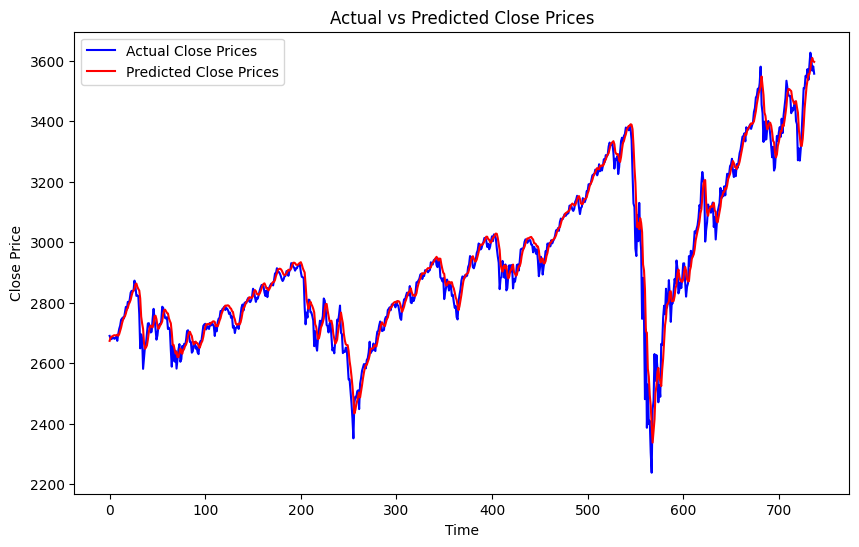

Dataframe GSPC is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0713 - val_loss: 0.0030
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0023 - val_loss: 6.9305e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 9.0536e-05 - val_loss: 5.6053e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.8833e-05 - val_loss: 5.1246e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.3403e-05 - val_loss: 5.0704e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.2815e-05 - val_loss: 5.2239e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 7.0347e-05 - val_loss: 4.7091e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.4302e-05 - val_loss: 4.1330e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.9538e-05 - val_loss: 4.0211e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.7268e-05 - val_loss: 4.0350e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0477 - val_

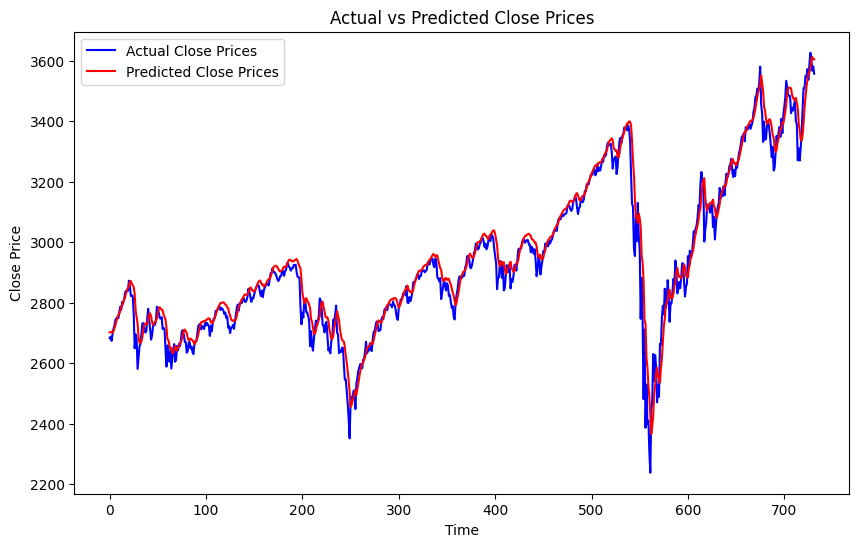

Dataframe GSPC is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0470 - val_loss: 7.5813e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.2111e-04 - val_loss: 5.2623e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.7052e-05 - val_loss: 4.8612e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.7468e-05 - val_loss: 4.9072e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 6.8569e-05 - val_loss: 4.9895e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.4043e-05 - val_loss: 4.7831e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.1702e-05 - val_loss: 4.1834e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.0994e-05 - val_loss: 4.1867e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.3307e-05 - val_loss: 3.9793e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.9611e-05 - val_loss: 3.8737e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.043

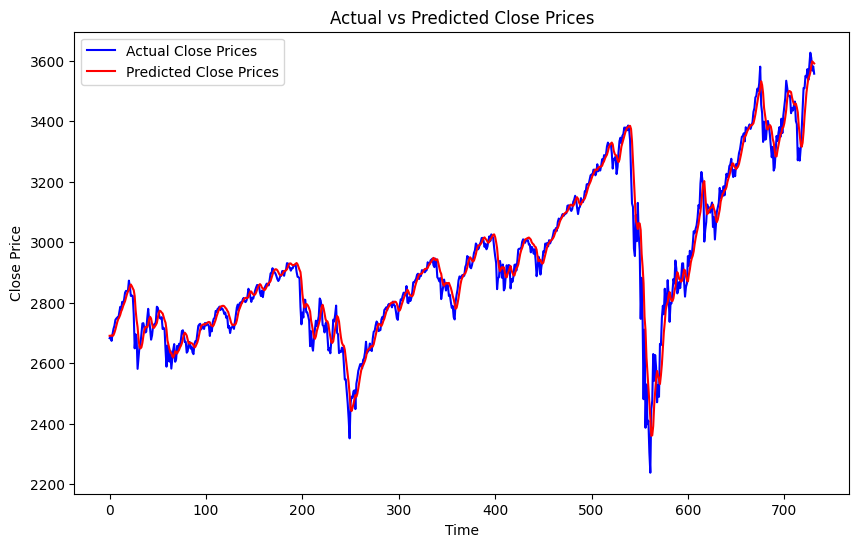

Dataframe GSPC is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0174 - val_loss: 3.8823e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.4893e-05 - val_loss: 3.8079e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.0337e-05 - val_loss: 3.7401e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.4226e-05 - val_loss: 3.6204e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.0487e-05 - val_loss: 3.5293e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.9846e-05 - val_loss: 3.9371e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.4104e-05 - val_loss: 3.4635e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 4.7658e-05 - val_loss: 3.3493e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 4.7531e-05 - val_loss: 3.2120e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.7627e-05 - val_loss: 3.2045e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.031

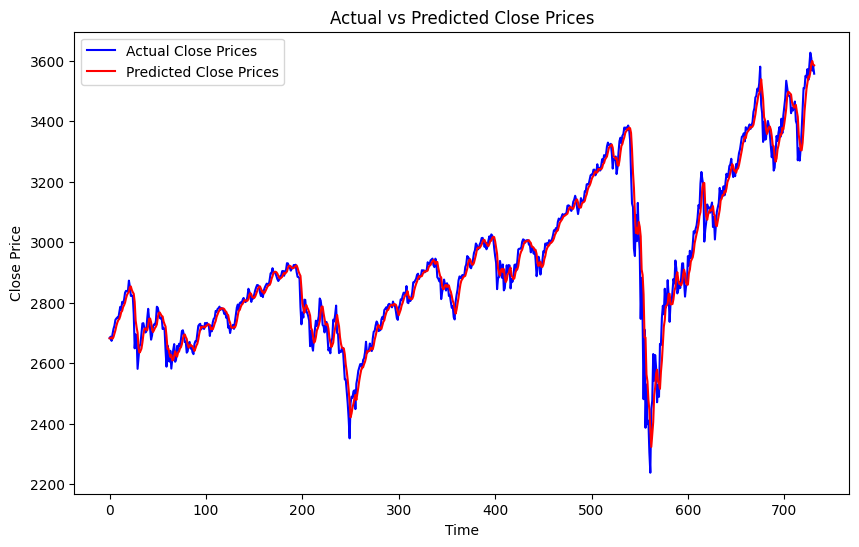

Dataframe GSPC is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0312 - val_loss: 8.0497e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.5645e-04 - val_loss: 6.1437e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.3153e-05 - val_loss: 6.1588e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.2980e-05 - val_loss: 5.8258e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.7549e-05 - val_loss: 5.6584e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.0597e-05 - val_loss: 5.4950e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.1316e-05 - val_loss: 5.3826e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.6384e-05 - val_loss: 5.3169e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.4484e-05 - val_loss: 5.2824e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.1253e-05 - val_loss: 5.0311e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.033

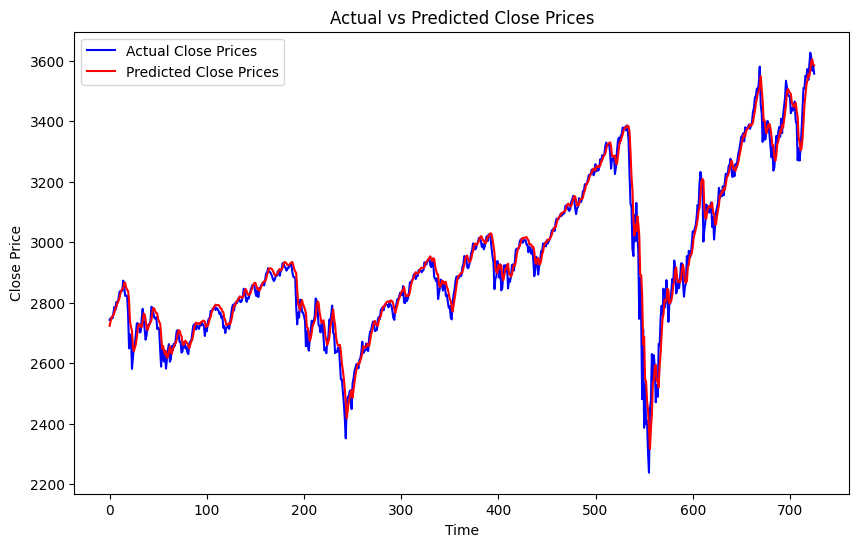

Dataframe GSPC is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0447 - val_loss: 5.7800e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 4.0635e-04 - val_loss: 6.7229e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.6825e-05 - val_loss: 6.6195e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.1610e-05 - val_loss: 6.4311e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.9496e-05 - val_loss: 6.1890e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.1297e-05 - val_loss: 6.0833e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.2358e-05 - val_loss: 6.1046e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 5.7849e-05 - val_loss: 5.7470e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.8634e-05 - val_loss: 5.6708e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.9918e-05 - val_loss: 5.4041e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.102

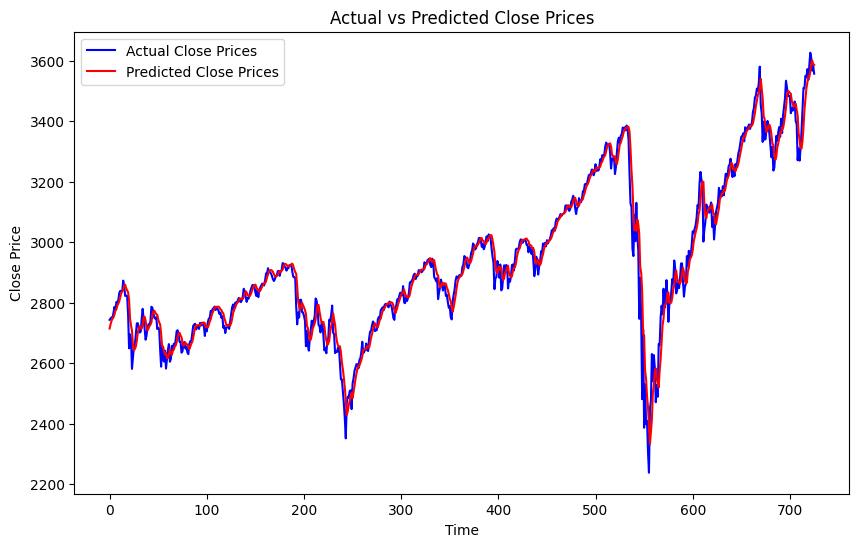

Dataframe GSPC is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0256 - val_loss: 1.4593e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 6.3833e-05 - val_loss: 5.9533e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.5871e-05 - val_loss: 5.6558e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 5.1645e-05 - val_loss: 5.4851e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.5421e-05 - val_loss: 5.3097e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.6871e-05 - val_loss: 5.2347e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 4.9338e-05 - val_loss: 5.1543e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.8056e-05 - val_loss: 4.9305e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.3590e-05 - val_loss: 4.8260e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 4.7757e-05 - val_loss: 5.3536e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.032

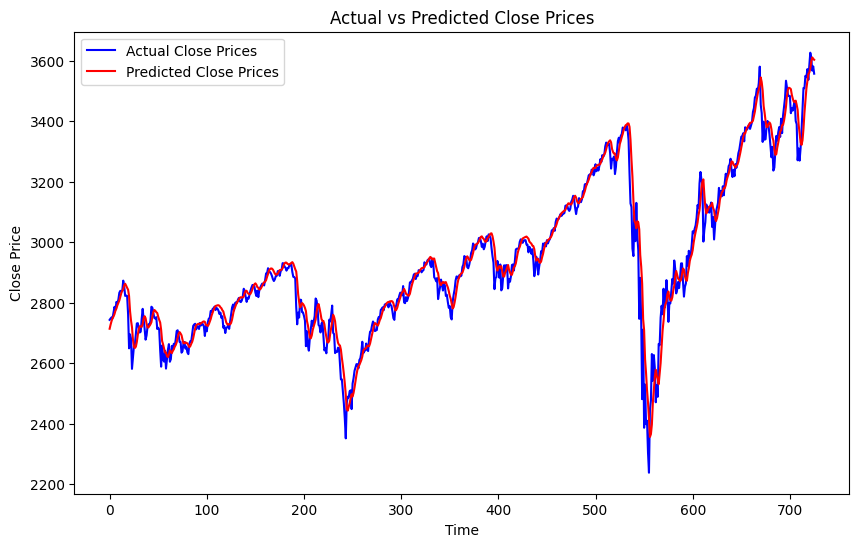







Dataframe DJI is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0291 - val_loss: 0.0012
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.5646e-04 - val_loss: 4.2144e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5800e-05 - val_loss: 4.0890e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.0080e-05 - val_loss: 4.0071e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6342e-05 - val_loss: 4.0077e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5865e-05 - val_loss: 3.7817e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3289e-05 - val_loss: 3.8880e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5045e-05 - val_loss: 3.7444e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3840e-05 - val_loss: 3.5537e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3566e-05 - val_loss: 3.4934e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0585 - 

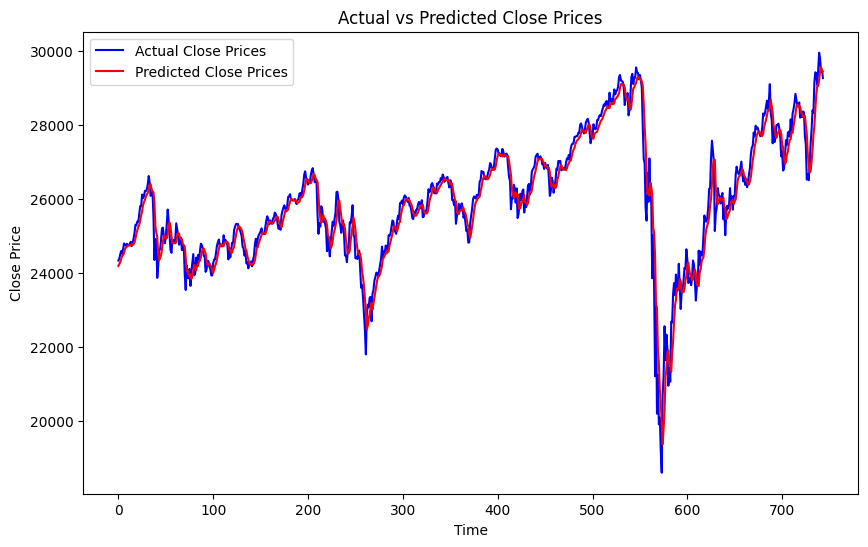

Dataframe DJI is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0197 - val_loss: 2.0286e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.1120e-04 - val_loss: 3.9725e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1709e-05 - val_loss: 3.8069e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7819e-05 - val_loss: 3.6811e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.1457e-05 - val_loss: 3.5992e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1099e-05 - val_loss: 3.5256e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1496e-05 - val_loss: 3.5119e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9900e-05 - val_loss: 3.3037e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7224e-05 - val_loss: 3.3543e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9409e-05 - val_loss: 3.3065e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.024

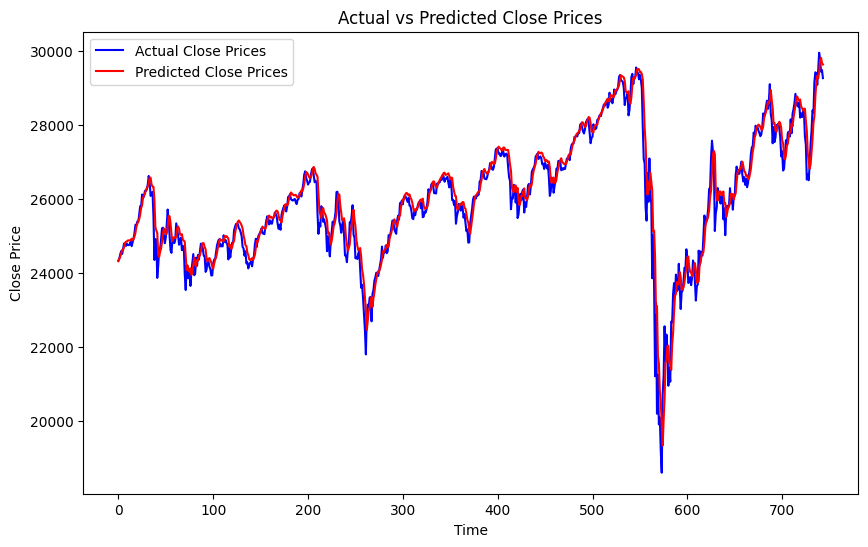

Dataframe DJI is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0328 - val_loss: 2.4357e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3944e-04 - val_loss: 4.7116e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6205e-05 - val_loss: 4.7170e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3839e-05 - val_loss: 4.5588e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7158e-05 - val_loss: 4.2418e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4535e-05 - val_loss: 4.2803e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4788e-05 - val_loss: 4.3792e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2706e-05 - val_loss: 3.8541e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2697e-05 - val_loss: 3.7492e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2995e-05 - val_loss: 3.6368e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.019

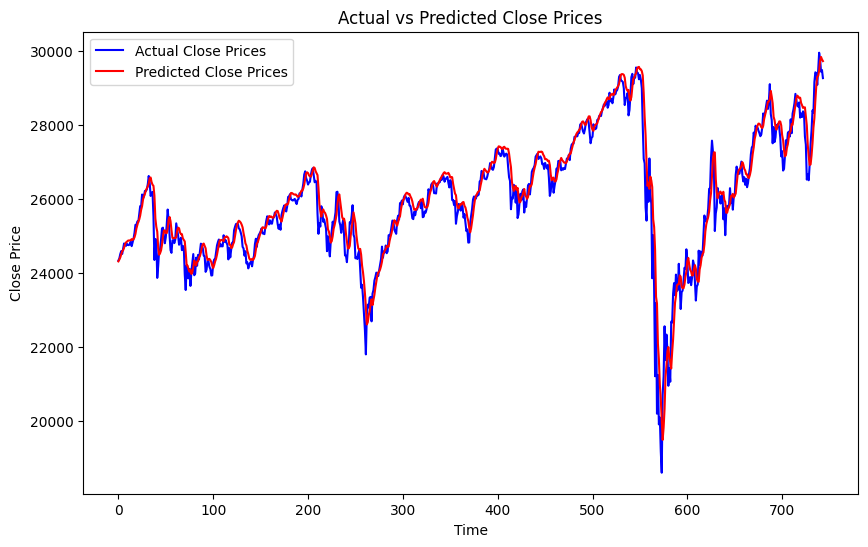

Dataframe DJI is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0455 - val_loss: 0.0022
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 6.9543e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.7516e-05 - val_loss: 5.1508e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.2693e-05 - val_loss: 5.4911e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.3244e-05 - val_loss: 4.6628e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.7484e-05 - val_loss: 4.8653e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.0535e-05 - val_loss: 4.3853e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.0555e-05 - val_loss: 4.3704e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.1485e-05 - val_loss: 4.2743e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.7951e-05 - val_loss: 4.1471e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0368 - val_

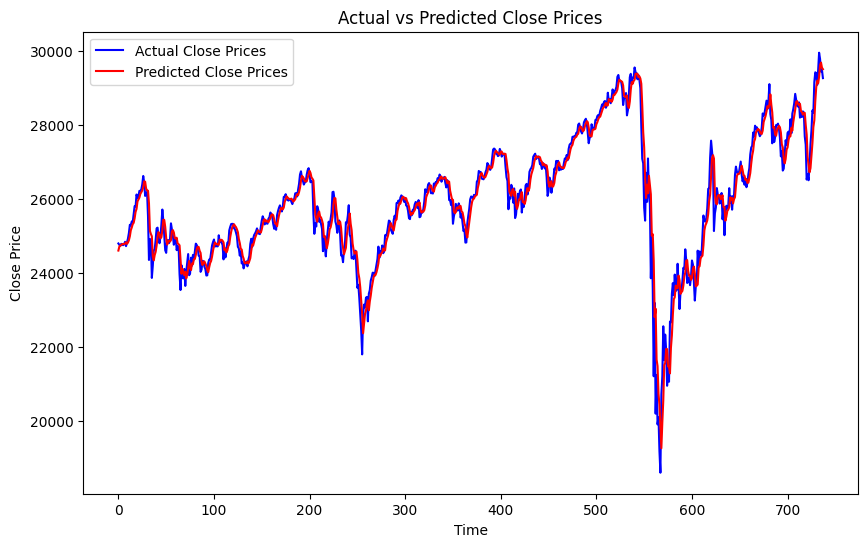

Dataframe DJI is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0503 - val_loss: 8.0432e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.1629e-04 - val_loss: 4.8492e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.1545e-05 - val_loss: 4.7150e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.1724e-05 - val_loss: 4.6603e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.2325e-05 - val_loss: 4.4423e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.0552e-05 - val_loss: 4.3153e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.6169e-05 - val_loss: 4.4480e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.8236e-05 - val_loss: 4.1167e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.7789e-05 - val_loss: 4.0274e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3753e-05 - val_loss: 3.9106e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.049

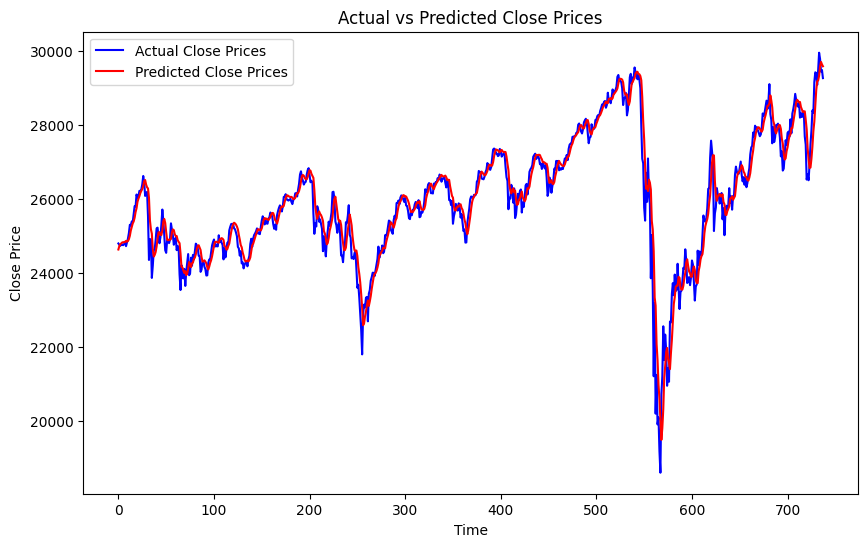

Dataframe DJI is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0426 - val_loss: 1.5252e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.9162e-04 - val_loss: 5.0221e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.6413e-05 - val_loss: 4.8781e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.5584e-05 - val_loss: 4.7473e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.8916e-05 - val_loss: 4.8178e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.5229e-05 - val_loss: 4.5465e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 6.4391e-05 - val_loss: 4.3750e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.0197e-05 - val_loss: 4.4914e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.0324e-05 - val_loss: 4.2603e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.0095e-05 - val_loss: 4.1256e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.028

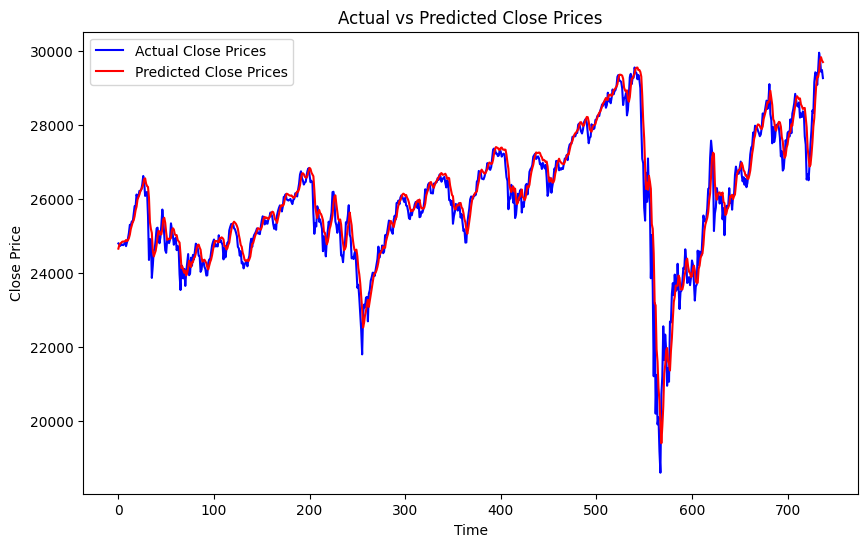

Dataframe DJI is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0412 - val_loss: 0.0017
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0011 - val_loss: 5.3388e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.9726e-05 - val_loss: 5.3840e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 7.0218e-05 - val_loss: 4.9436e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.9083e-05 - val_loss: 4.7973e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.9099e-05 - val_loss: 4.8711e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.5411e-05 - val_loss: 4.5889e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.0197e-05 - val_loss: 4.4523e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.7888e-05 - val_loss: 4.4368e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.2644e-05 - val_loss: 4.4560e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0268 - val_

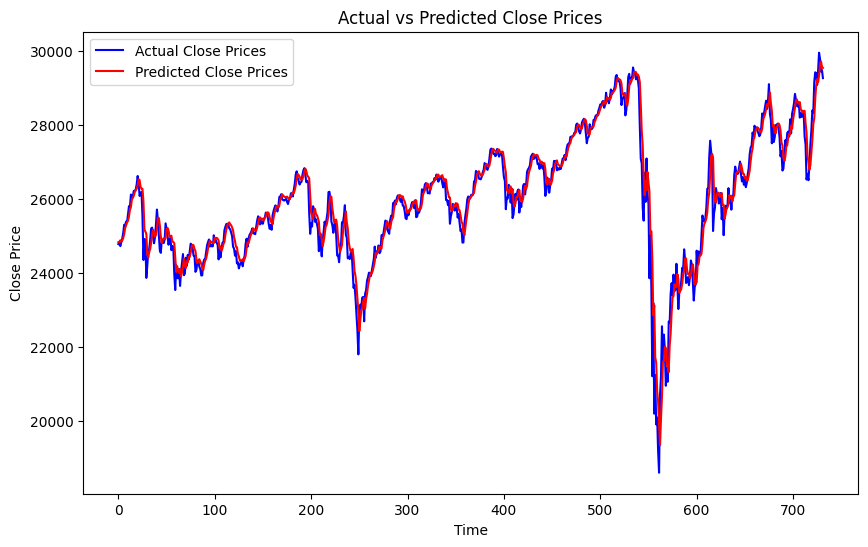

Dataframe DJI is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0872 - val_loss: 0.0029
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0016 - val_loss: 7.9381e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0082e-04 - val_loss: 6.1773e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.4041e-05 - val_loss: 5.7462e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.3730e-05 - val_loss: 5.4549e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.7958e-05 - val_loss: 5.7367e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.4001e-05 - val_loss: 5.1638e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.7587e-05 - val_loss: 5.1723e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.9215e-05 - val_loss: 5.0235e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.6618e-05 - val_loss: 4.7095e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0373 - val_

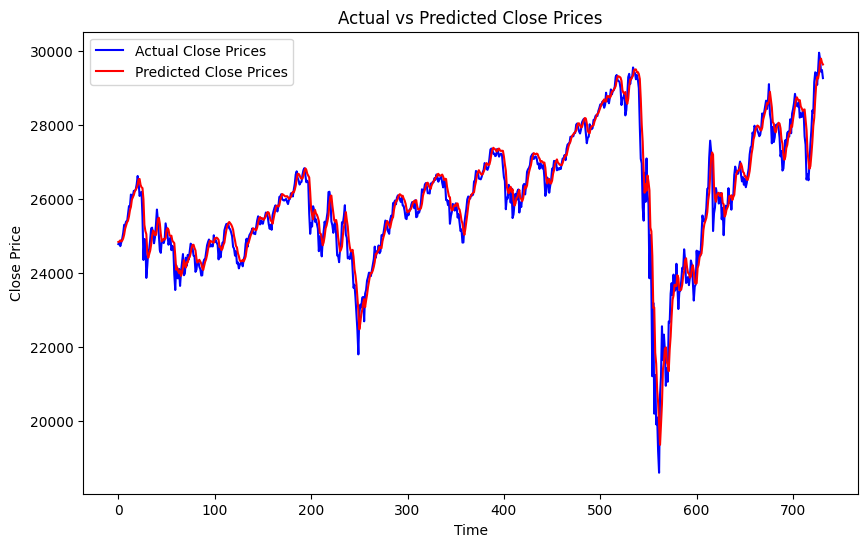

Dataframe DJI is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0321 - val_loss: 3.2805e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.1500e-04 - val_loss: 4.8145e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 6.5927e-05 - val_loss: 4.6906e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.3297e-05 - val_loss: 4.5710e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 6.0148e-05 - val_loss: 4.4473e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.8555e-05 - val_loss: 4.5379e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.3290e-05 - val_loss: 4.2136e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.6049e-05 - val_loss: 4.1060e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.4442e-05 - val_loss: 4.0298e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 5.5480e-05 - val_loss: 3.9165e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.057

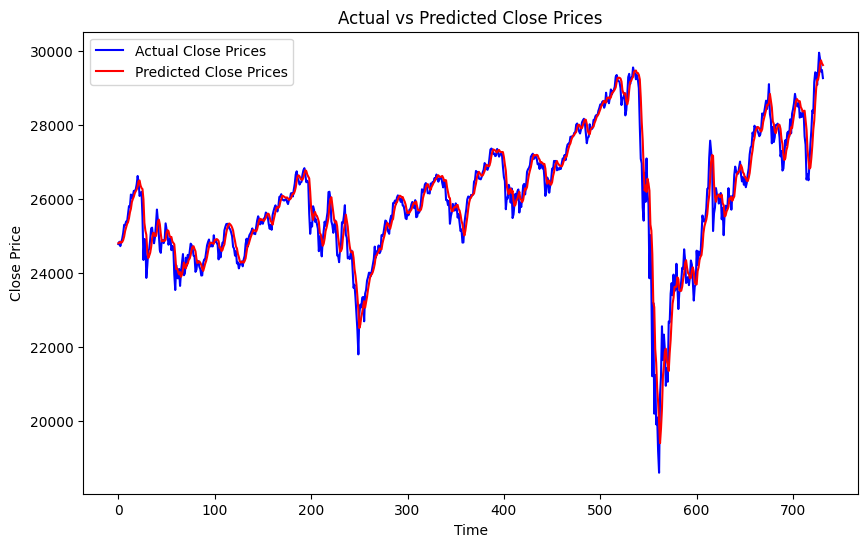

Dataframe DJI is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0534 - val_loss: 0.0027
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0015 - val_loss: 7.9186e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.9233e-05 - val_loss: 7.5519e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 7.1642e-05 - val_loss: 7.4557e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.6336e-05 - val_loss: 7.0608e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.0094e-05 - val_loss: 6.8488e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.1674e-05 - val_loss: 6.6541e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.8075e-05 - val_loss: 6.5086e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.6578e-05 - val_loss: 6.3731e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.2635e-05 - val_loss: 6.2197e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0856 - val_

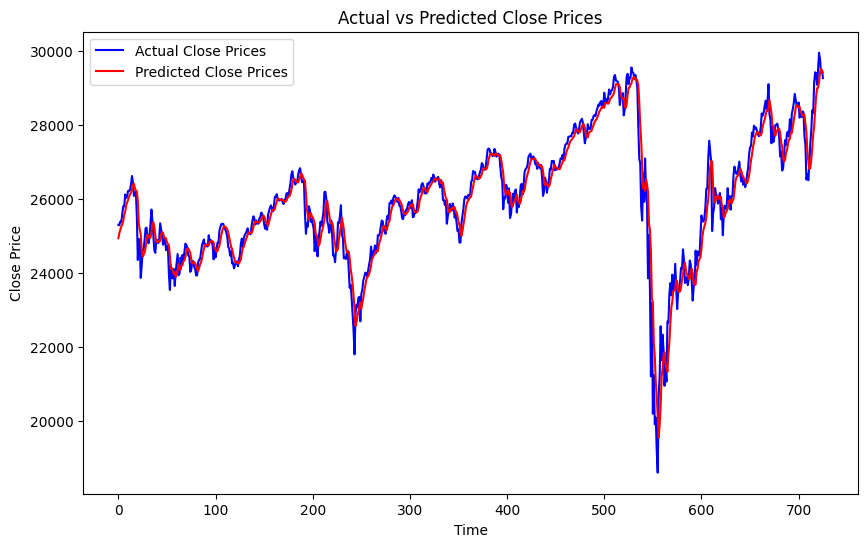

Dataframe DJI is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0309 - val_loss: 3.0451e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 2.0343e-04 - val_loss: 7.8599e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.7512e-05 - val_loss: 7.5746e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.2401e-05 - val_loss: 7.3385e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 6.5770e-05 - val_loss: 7.1820e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 6.2579e-05 - val_loss: 6.9914e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 5.8739e-05 - val_loss: 6.7034e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 5.3390e-05 - val_loss: 6.7825e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 6.0209e-05 - val_loss: 6.4217e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 5.6278e-05 - val_loss: 6.1641e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.047

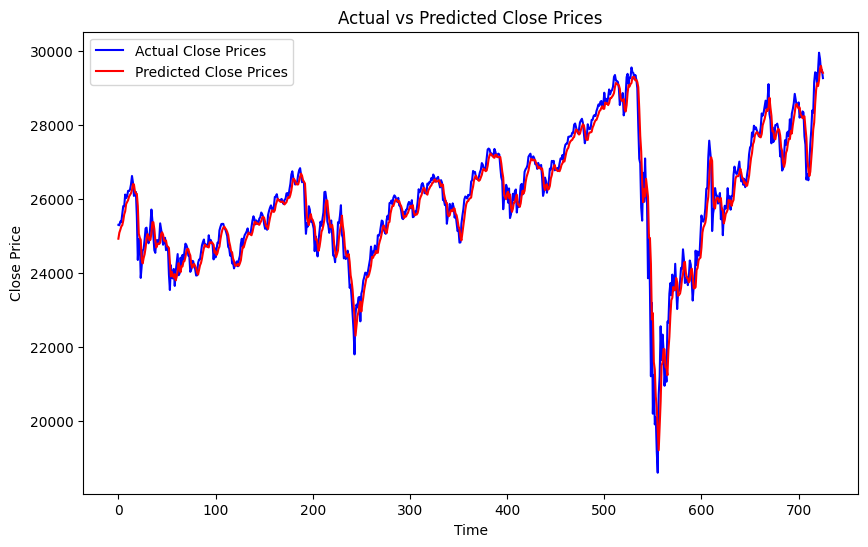

Dataframe DJI is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0594 - val_loss: 5.9078e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 3.0313e-04 - val_loss: 9.2300e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 8.5769e-05 - val_loss: 8.8968e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 8.4999e-05 - val_loss: 8.6104e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 7.8767e-05 - val_loss: 8.3518e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 7.3356e-05 - val_loss: 8.0078e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 6.7364e-05 - val_loss: 7.9336e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.8334e-05 - val_loss: 7.6165e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 6.5992e-05 - val_loss: 7.4441e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 7.2313e-05 - val_loss: 7.1982e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.051

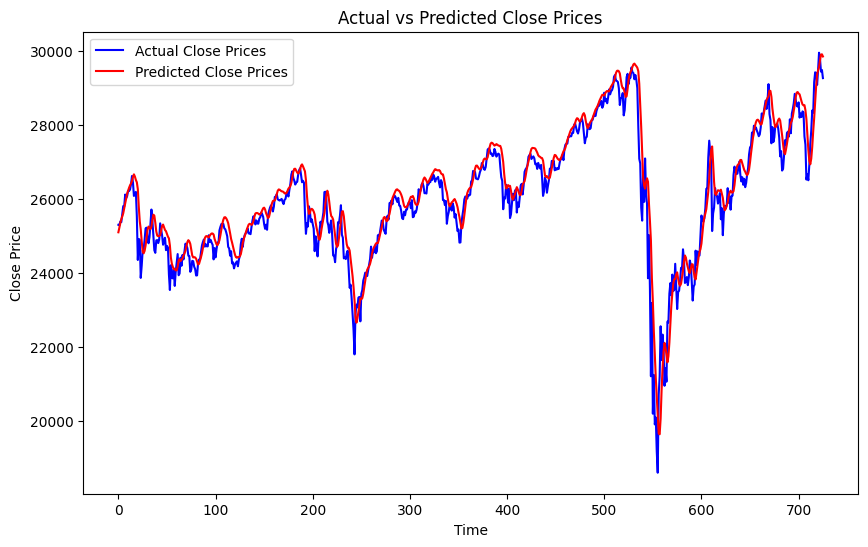







{'IXIC': (60, 50, <Sequential name=sequential_20, built=True>, 100.73795043614497), 'W5000': (60, 50, <Sequential name=sequential_83, built=True>, 274.9669161295793), 'XLK': (90, 50, <Sequential name=sequential_155, built=True>, 1.1404407428262011), 'GSPC': (120, 32, <Sequential name=sequential_229, built=True>, 28.656012585012057), 'DJI': (90, 32, <Sequential name=sequential_272, built=True>, 260.9988339950478)}


In [6]:
# This will run for about 20-25 mins
k = [30,60,90,120]
neurons = [32,50,70]
models={}
for i in range(len(time_series)):
    model_desc = []
    for hyperparameter_k in k:
        for hyperparameter_neurons in neurons:
            model_desc.append(fit_gru(hyperparameter_k,hyperparameter_neurons,time_series[i],i))
    best_tuned = (1,1,1,float('inf') ) # dummy init
    for model in model_desc:
        if (model[3]<best_tuned[3]):
            best_tuned = model
    models[stock_index[i]] = best_tuned
    print ("\n\n\n\n\n")
    
print (models)

# Results of Hyperparameter tuning of GRU implementation

In [7]:
for stock, best_model in models.items():
    print(f"Stock: {stock}")
    print(f"  Hyperparameter k: {best_model[0]}")
    print(f"  Hyperparameter neurons: {best_model[1]}")
    print(f"  Model ID: {best_model[2]}")
    print(f"  Model Loss: {best_model[3]}")
    print("\n" + "-"*50 + "\n")  # Divider between models


Stock: IXIC
  Hyperparameter k: 60
  Hyperparameter neurons: 50
  Model ID: <Sequential name=sequential_20, built=True>
  Model Loss: 100.73795043614497

--------------------------------------------------

Stock: W5000
  Hyperparameter k: 60
  Hyperparameter neurons: 50
  Model ID: <Sequential name=sequential_83, built=True>
  Model Loss: 274.9669161295793

--------------------------------------------------

Stock: XLK
  Hyperparameter k: 90
  Hyperparameter neurons: 50
  Model ID: <Sequential name=sequential_155, built=True>
  Model Loss: 1.1404407428262011

--------------------------------------------------

Stock: GSPC
  Hyperparameter k: 120
  Hyperparameter neurons: 32
  Model ID: <Sequential name=sequential_229, built=True>
  Model Loss: 28.656012585012057

--------------------------------------------------

Stock: DJI
  Hyperparameter k: 90
  Hyperparameter neurons: 32
  Model ID: <Sequential name=sequential_272, built=True>
  Model Loss: 260.9988339950478

---------------------

# Stock Price Prediction Using Support Vector Regression (SVR)

Predicting stock prices is a complex problem due to market volatility, non-linear relationships, and the influence of numerous factors. One powerful approach for capturing non-linear patterns is **Support Vector Regression (SVR)**, which is an extension of the Support Vector Machine (SVM) technique for regression tasks.

## What is SVR?

**Support Vector Regression (SVR)** is a type of regression model based on the principles of **Support Vector Machines (SVM)**. SVR aims to find a function that approximates the relationship between input features and a continuous output (e.g., stock prices). Unlike linear regression, SVR can model **non-linear relationships** using different kernel functions.

### Key Concepts:
1. **Epsilon-insensitive loss**: SVR introduces a margin of tolerance (epsilon) within which errors are ignored, and the model does not penalize predictions. This creates a "tube" around the true data, allowing some flexibility.
   
2. **Support Vectors**: Only data points that fall outside this epsilon margin contribute to defining the model, making SVR less sensitive to outliers.

3. **Kernels**: SVR can use various kernel functions (e.g., **linear, polynomial, radial basis function (RBF)**) to map the data into higher-dimensional spaces, enabling it to capture complex, non-linear relationships in stock price movements.

## Why Use SVR for Stock Price Prediction?

1. **Handling Non-Linear Relationships**: Stock prices are influenced by multiple non-linear factors, and SVR, especially with non-linear kernels like **RBF**, can capture these complex patterns better than linear models.

2. **Robustness to Outliers**: SVR focuses on the most important data points (support vectors) and ignores insignificant data, making it robust to noisy stock data, where occasional large fluctuations can occur.

3. **Generalization**: SVR is known for its ability to generalize well, meaning it is less likely to overfit to training data, especially when tuned carefully with cross-validation.

## Dataset

We use historical stock price data that includes features like:
- **Date**
- **Close** prices


The goal is to predict the **Close** price of the stock using the past features and other relevant information.

## Approach

1. **Data Preprocessing**: We first normalize the features (stock prices, volume) to ensure the data is on a consistent scale for SVR.

2. **Modeling with SVR**: We implement an SVR model using **`scikit-learn`**. The model is configured with the following:
   - **Kernel**: We experiment with different kernels (e.g., RBF, linear) to capture both linear and non-linear relationships in the stock price data.
   - **Hyperparameter tuning**: Parameters like **C**, **epsilon**, and **gamma** are optimized using grid search or random search techniques to find the best model configuration.

3. **Evaluation**: We evaluate the SVR model using metrics such as **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**, comparing its performance with other models like GRU.


# Support Vector Regression on all 5 indices

In [8]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [9]:
def fit_svr(hyperparameter_k, hyperparameter_c, hyperparameter_gamma, df, df_ind):
#     print (f"Dataset {stock_index[df_ind]} is being loaded ... ")
#     print(f"Training for sequence length: {hyperparameter_k}, C: {hyperparameter_c}, Gamma: {hyperparameter_gamma}")
    close_prices = df.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(close_prices)
    
    sequence_length = hyperparameter_k  
    X, y = create_sequences(scaled_close, sequence_length)

    # Train-test split (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape X for SVR input (flatten the sequences)
    X_train_svr = X_train.reshape(X_train.shape[0], -1)
    X_test_svr = X_test.reshape(X_test.shape[0], -1)

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=False)

    # To store validation losses and the best model
    best_val_loss = float('inf')
    best_model = None
    best_hyperparameters = None

    # Train SVR with KFold
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_svr)):
        X_train_fold, X_val_fold = X_train_svr[train_index], X_train_svr[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Define the SVR model
        svr_model = SVR(kernel='rbf', C=hyperparameter_c, gamma=hyperparameter_gamma, epsilon=0.01)

        # Train the model
        svr_model.fit(X_train_fold, y_train_fold)

        # Validation predictions and loss
        y_val_pred = svr_model.predict(X_val_fold)
        val_loss = mean_squared_error(y_val_fold, y_val_pred)

        # Keep track of the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = svr_model
            best_hyperparameters = (hyperparameter_k, hyperparameter_c, hyperparameter_gamma)

    # Final evaluation on the test set with the best model
    y_test_pred = best_model.predict(X_test_svr)
    
    # Inverse scaling to compare with original prices
    y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Print test performance
    test_loss = mean_absolute_error(y_test_pred_actual, y_test_actual)
#     print(f"Best Model: k={best_hyperparameters[0]}, C={best_hyperparameters[1]}, Gamma={best_hyperparameters[2]}")
#     print(f"Validation Loss: {best_val_loss}, Test Loss: {test_loss}")

#     # Plot the actual vs predicted close prices
#     plt.figure(figsize=(10, 6))
#     plt.plot(y_test_actual, label="Actual Close Prices", color='blue')
#     plt.plot(y_test_pred_actual, label="Predicted Close Prices (SVR)", color='red')
#     plt.title(f"Actual vs Predicted Close Prices (SVR) - Best Model")
#     plt.xlabel("Time")
#     plt.ylabel("Close Price")
#     plt.legend()
#     plt.show()

    return best_model, best_hyperparameters, best_val_loss, test_loss, y_test_pred_actual , y_test_actual


Grid search completed Dataset IXIC
Best Overall Model: k=30, C=2000, Gamma=0.01
Best Validation Loss: 7.1834721672737274e-06, Best Test Loss: 110.72268934274506


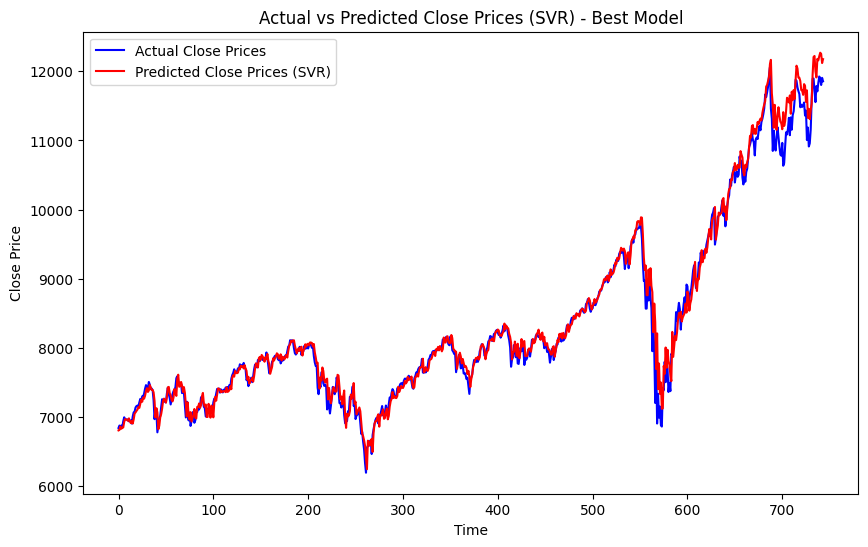


--------------------------------------------------

Grid search completed Dataset W5000
Best Overall Model: k=30, C=16, Gamma=0.08
Best Validation Loss: 2.108730917051224e-05, Best Test Loss: 459.89880454380295


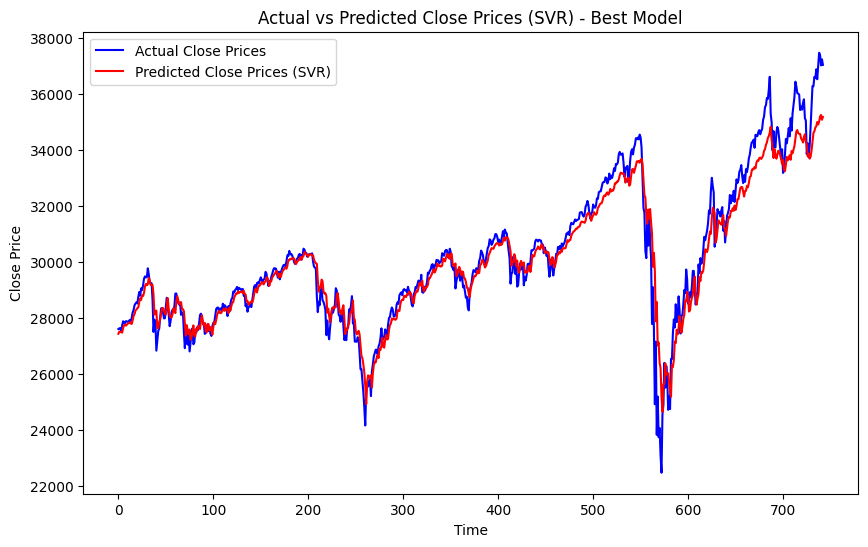


--------------------------------------------------

Grid search completed Dataset XLK
Best Overall Model: k=30, C=128, Gamma=0.060000000000000005
Best Validation Loss: 9.945279646033346e-06, Best Test Loss: 1.8862833657589868


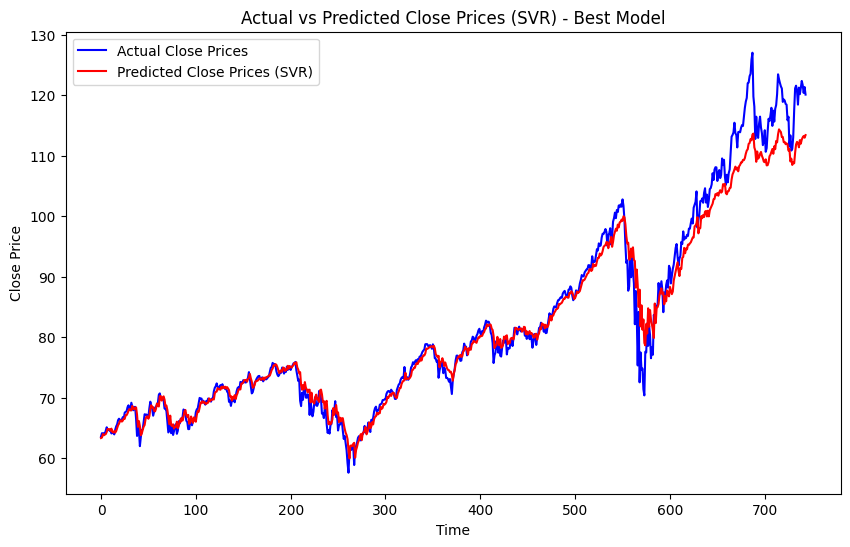


--------------------------------------------------

Grid search completed Dataset GSPC
Best Overall Model: k=30, C=32, Gamma=0.060000000000000005
Best Validation Loss: 2.2119291089959844e-05, Best Test Loss: 33.02135657604232


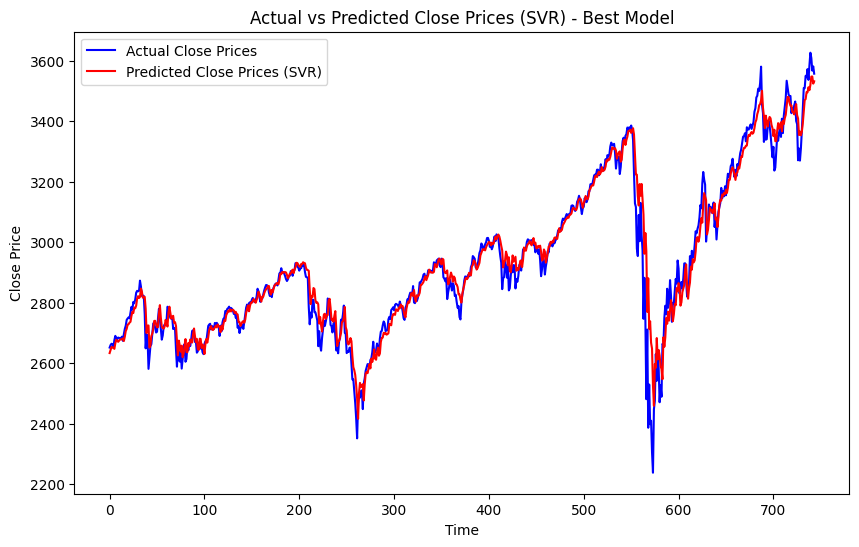


--------------------------------------------------

Grid search completed Dataset DJI
Best Overall Model: k=30, C=512, Gamma=0.01
Best Validation Loss: 2.4593838454999508e-05, Best Test Loss: 275.59500375530274


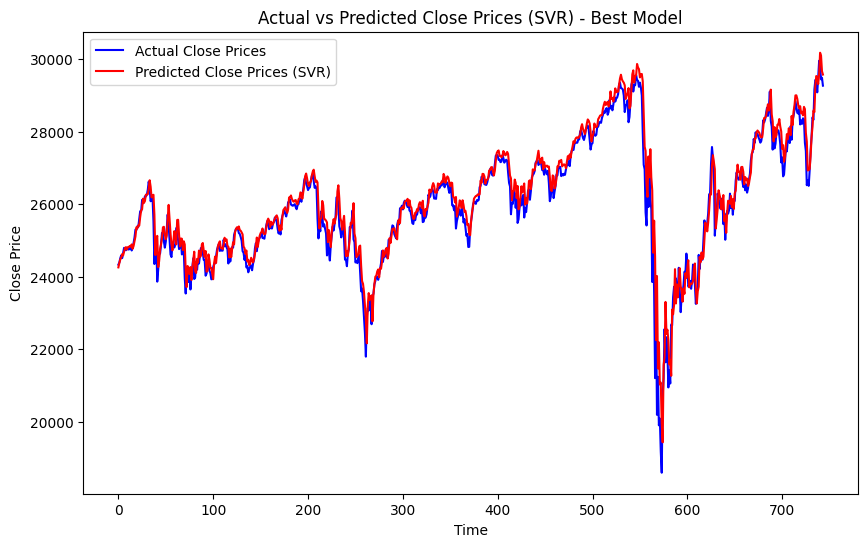


--------------------------------------------------



In [10]:
# Grid search setup
k_values = [30, 60, 90]
c_values = [0.1, 0.5, 1, 2, 4, 16, 32, 64, 128, 512, 1000, 2000]
gamma_values = np.arange(0.01, 0.1, 0.01).tolist()
# Perform the grid search for each time series
for i in range(len(time_series)):
    best_overall_model = None
    best_overall_hyperparameters = None
    best_overall_val_loss = float('inf')
    best_overall_test_loss = float('inf')
    best_yp = None
    best_ya = None
    for hyperparameter_k in k_values:
        for hyperparameter_c in c_values:
            for hyperparameter_gamma in gamma_values:
                model, hyperparameters, val_loss, test_loss,yp,ya = fit_svr(hyperparameter_k, hyperparameter_c, hyperparameter_gamma, time_series[i], i)
                
                # Track the overall best model across all searches
                if val_loss < best_overall_val_loss:
                    best_overall_val_loss = val_loss
                    best_overall_test_loss = test_loss
                    best_overall_model = model
                    best_overall_hyperparameters = hyperparameters
                    best_yp = yp
                    best_ya = ya
    print (f"Grid search completed Dataset {stock_index[i]}")
    # Print the best overall results
    print(f"Best Overall Model: k={best_overall_hyperparameters[0]}, C={best_overall_hyperparameters[1]}, Gamma={best_overall_hyperparameters[2]}")
    print(f"Best Validation Loss: {best_overall_val_loss}, Best Test Loss: {best_overall_test_loss}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(best_ya, label="Actual Close Prices", color='blue')
    plt.plot(best_yp, label="Predicted Close Prices (SVR)", color='red')
    plt.title(f"Actual vs Predicted Close Prices (SVR) - Best Model")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()
    print("\n" + "-"*50 + "\n")  # Divider between models
    

# Results of SVR (Exhaustive Grid Search)

## Grid Search Results

### Dataset IXIC
- **Best Overall Model**: 
  - k = 30 
  - C = 2000 
  - Gamma = 0.01
- **Best Validation Loss**: 7.183472167247379e-06
- **Best Test Loss**: 110.72268934295437

---

### Dataset W5000
- **Best Overall Model**: 
  - k = 30 
  - C = 16 
  - Gamma = 0.08
- **Best Validation Loss**: 2.108730917051086e-05
- **Best Test Loss**: 459.8988045437928

---

### Dataset XLK
- **Best Overall Model**: 
  - k = 30 
  - C = 128 
  - Gamma = 0.06
- **Best Validation Loss**: 9.94527964602975e-06
- **Best Test Loss**: 1.8862833657589515

---

### Dataset GSPC
- **Best Overall Model**: 
  - k = 30 
  - C = 32 
  - Gamma = 0.06
- **Best Validation Loss**: 2.2119291089964842e-05
- **Best Test Loss**: 33.02135657604585

---

### Dataset DJI
- **Best Overall Model**: 
  - k = 30 
  - C = 512 
  - Gamma = 0.01
- **Best Validation Loss**: 2.4593838454985532e-05
- **Best Test Loss**: 275.5950037550632


In [11]:
best_svr = [] 
best_svr.append([30, 2000, 0.01])
best_svr.append([30, 16, 0.08])
best_svr.append([30, 128, 0.06])
best_svr.append([30, 32, 0.06])
best_svr.append([30, 512, 0.01])

## Let us explore the stationarity aspect of the series for more accurate predictions

In [12]:
diff_time_series = [] # this list contains stationary versions of the time series (original)

In [13]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [14]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] > 0.05:
        print("\nThe series is non-stationary (fail to reject null hypothesis).")
    else:
        print("\nThe series is stationary (reject null hypothesis).")

ADF Test on IXIC:


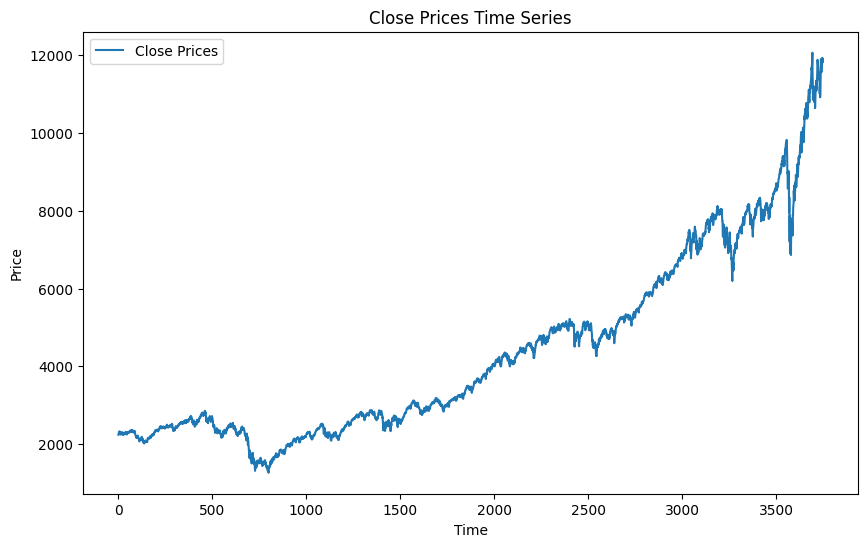

ADF Statistic: 2.5361027013109925
p-value: 0.9990605751787489
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


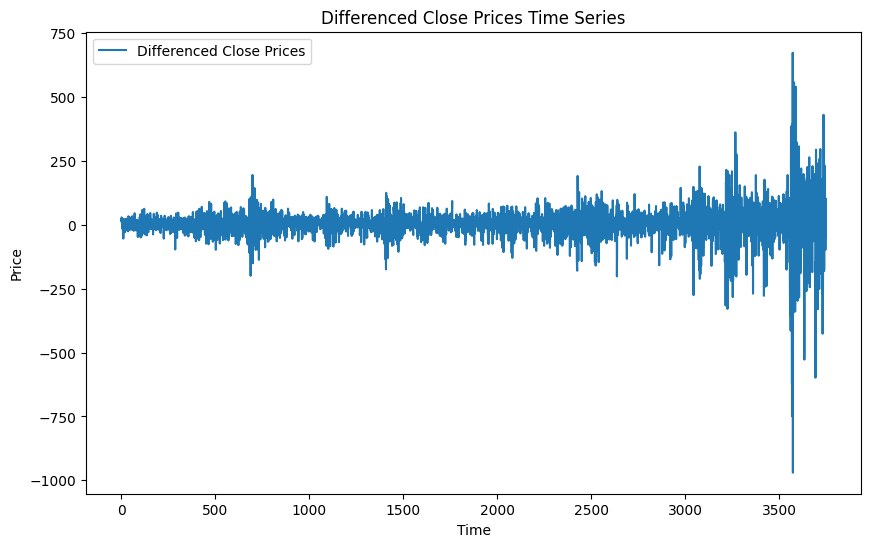


ADF Test on Differenced IXIC:
ADF Statistic: -11.743492696560967
p-value: 1.257378297080691e-21
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on W5000:


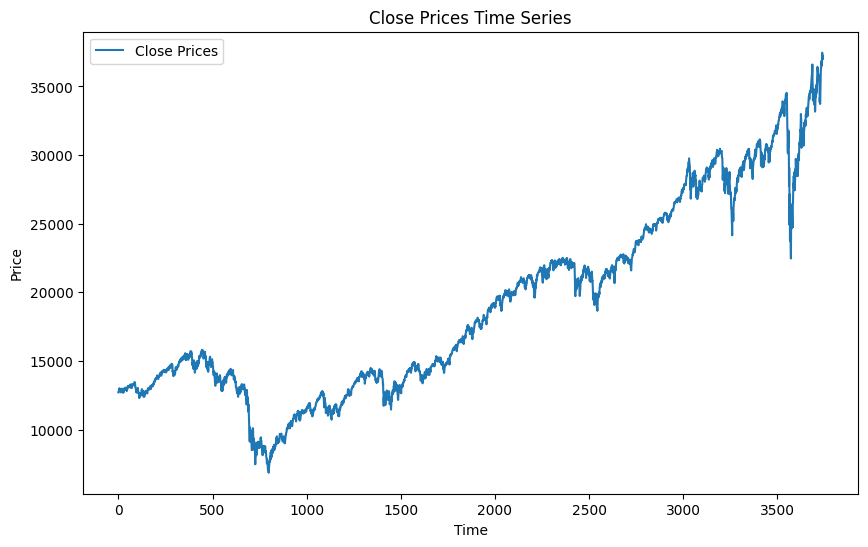

ADF Statistic: 0.6971614237507838
p-value: 0.9897810503961131
Critical Values:
   1%: -3.4321114600792098
   5%: -2.862318315640672
   10%: -2.567184308512469

The series is non-stationary (fail to reject null hypothesis).


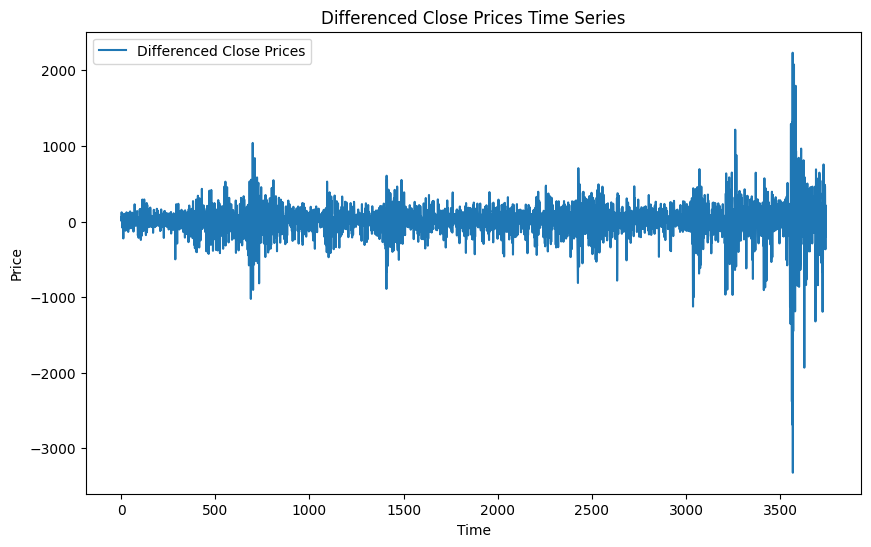


ADF Test on Differenced W5000:
ADF Statistic: -12.47670751870512
p-value: 3.156591673512311e-23
Critical Values:
   1%: -3.4321114600792098
   5%: -2.862318315640672
   10%: -2.567184308512469

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on XLK:


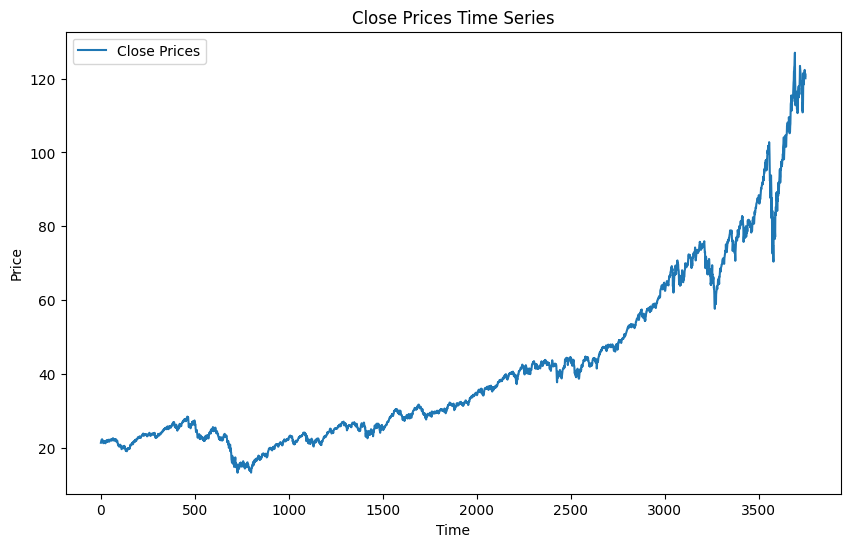

ADF Statistic: 2.721689994326571
p-value: 0.9990878552953746
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is non-stationary (fail to reject null hypothesis).


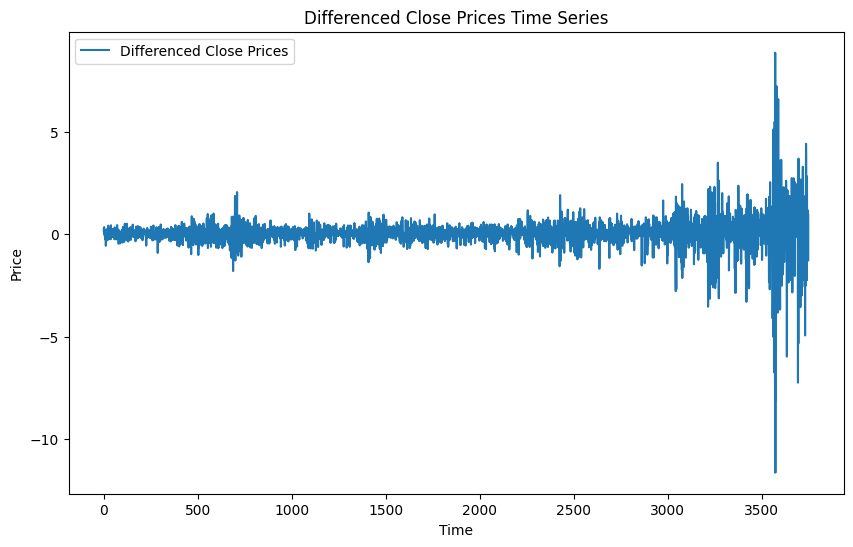


ADF Test on Differenced XLK:
ADF Statistic: -11.556470915385257
p-value: 3.3495903454194326e-21
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on GSPC:


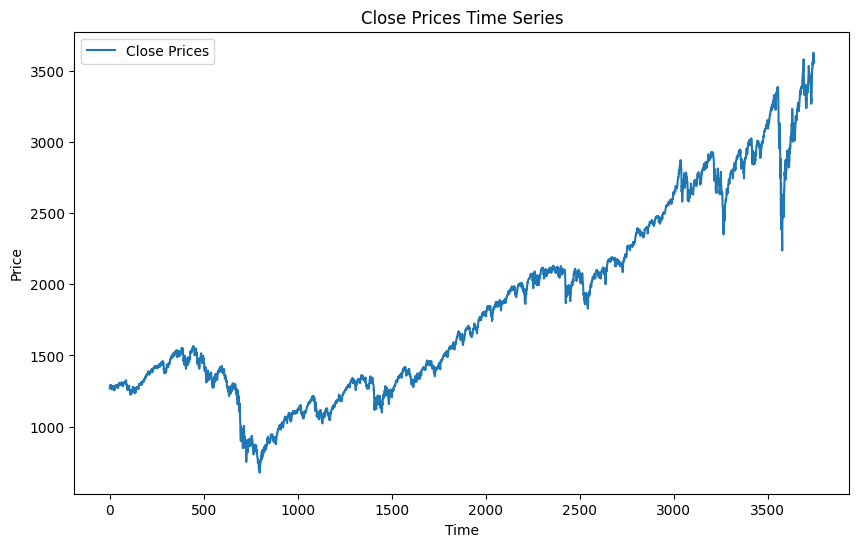

ADF Statistic: 0.8049391050612843
p-value: 0.9917154775535975
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


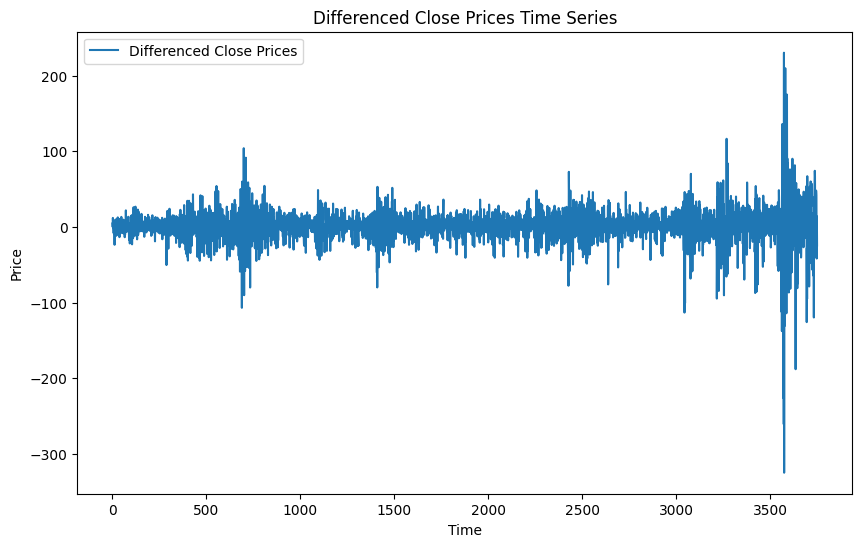


ADF Test on Differenced GSPC:
ADF Statistic: -12.629378067191672
p-value: 1.5166107132328842e-23
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on DJI:


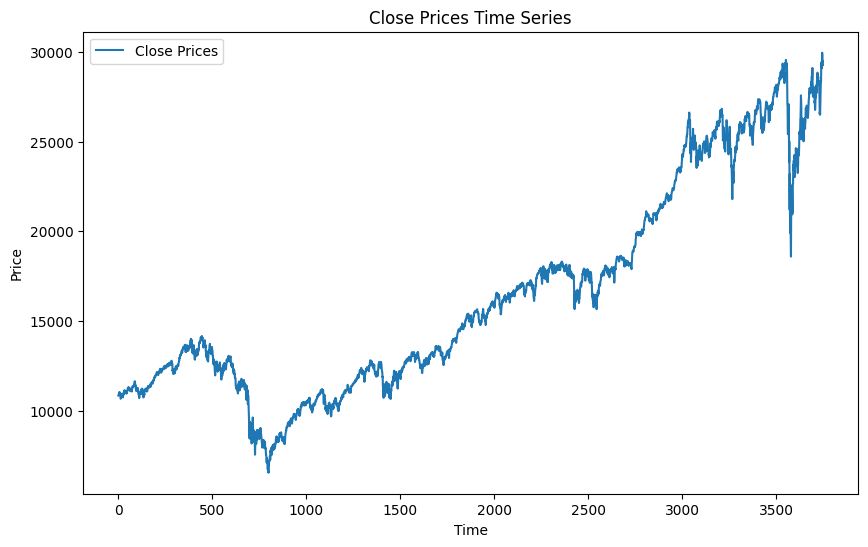

ADF Statistic: 0.16030367665123066
p-value: 0.9699451709884738
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


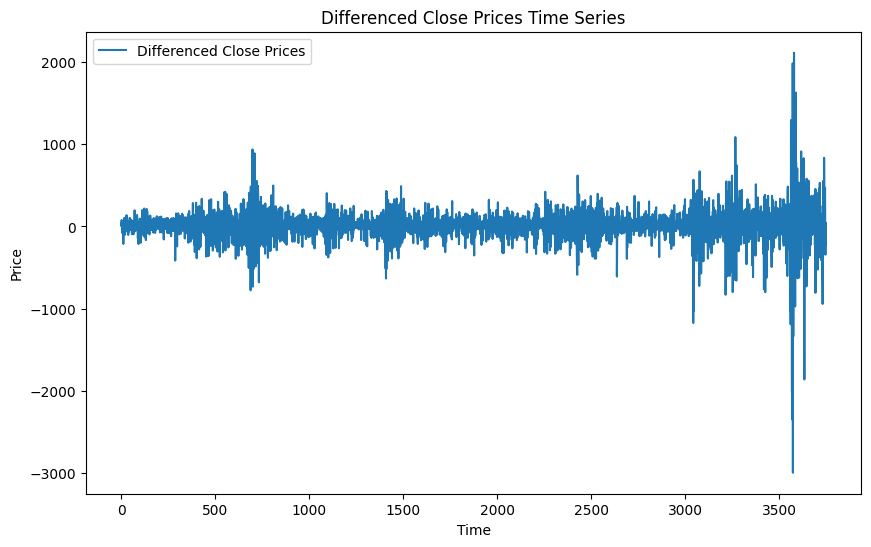


ADF Test on Differenced DJI:
ADF Statistic: -12.356731497205194
p-value: 5.664319258371578e-23
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is stationary (reject null hypothesis).
_____________________________________________________________




In [15]:
for i in range(5):
    # Perform ADF test on 'Close' prices
    print(f"ADF Test on {stock_index[i]}:")
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(time_series[i]), label='Close Prices')
    plt.title('Close Prices Time Series')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    adf_test(time_series[i])

    # Optional: If the series is non-stationary, you can difference it to make it stationary
    # Differencing the series (to remove trends and seasonality)
    diff_series = time_series[i].diff().dropna()
    
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(diff_series, label='Differenced Close Prices')
    plt.title('Differenced Close Prices Time Series')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Perform ADF test on the differenced series
    print(f"\nADF Test on Differenced {stock_index[i]}:")
    adf_test(diff_series)
    diff_time_series.append(diff_series)
    print ("_____________________________________________________________\n\n")

### Now fitting SVR on differenced version of the series

In [16]:
def reconstruct_series(diff_series, first_value):
    # Initialize the reconstructed series with the first known value
    reconstructed = [first_value]

    # Iterate through the differenced series and reconstruct
    for diff in diff_series:
        next_value = reconstructed[-1] + diff[0]
        reconstructed.append(next_value)

    return np.array(reconstructed)

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def fit_svr_with_grid_search(time_series,i):
    
    print (f"Stock {stock_index[i]} is being loaded...")
    data = time_series

    t = np.arange(len(data))

    # Step 1: Train-Test Split
    # Let's reserve 20% of the data for testing
    t_train, t_test, y_train, y_test = train_test_split(t, data.values, test_size=0.2, shuffle=False)

    # Step 2: Fit linear regression on the training set to capture the trend
    lr = LinearRegression()
    lr.fit(t_train.reshape(-1, 1), y_train)

    # Predicted trend for both training and testing data
    trend_train_pred = lr.predict(t_train.reshape(-1, 1))
    trend_test_pred = lr.predict(t_test.reshape(-1, 1))

    # Step 3: Calculate residuals (errors) from the trend for training data
    residuals_train = y_train - trend_train_pred

    # Step 4: Scale the time indices for SVR
    scaler = StandardScaler()
    t_train_scaled = scaler.fit_transform(t_train.reshape(-1, 1))
    t_test_scaled = scaler.transform(t_test.reshape(-1, 1))

    # Step 5: Define the SVR model and perform grid search
    svr = SVR(kernel='rbf')
    param_grid = {
        'C': [0.1, 1, 10, 100,1000,2000],      # Regularization parameter
        'gamma': ['scale',0.5, 0.1, 0.01, 0.001],  # Kernel coefficient
        'epsilon': [0.01, 0.1, 0.2]   # Epsilon in the epsilon-SVR model
    }

    grid_search = GridSearchCV(svr, param_grid, cv=KFold(n_splits=5, shuffle=False), scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(t_train_scaled, residuals_train)

    # Step 6: Predict using the best estimator from the grid search
    best_svr = grid_search.best_estimator_

    error_train_pred = best_svr.predict(t_train_scaled)
    error_test_pred = best_svr.predict(t_test_scaled)

    # Step 7: Combine the trend and SVR-predicted errors to get the final predictions
    final_train_pred = trend_train_pred + error_train_pred
    final_test_pred = trend_test_pred + error_test_pred

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(final_test_pred, y_test)
    print(f"Mean Absolute Error on Test Set: {mae}")

    # Step 8: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, data, label='Original Time Series')
    plt.plot(t_train, final_train_pred, label='Train Prediction (Trend + SVR)', linestyle='-.')
    plt.plot(t_test, final_test_pred, label='Test Prediction (Trend + SVR)', linestyle='-.')
    plt.legend()
    plt.title('Time Series Decomposition with Linear Regression and SVR (with Grid Search)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

    # Print the best parameters and cross-validation score
    print(f"Best SVR parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")



Stock IXIC is being loaded...
Mean Absolute Error on Test Set: 1632.7167879568674


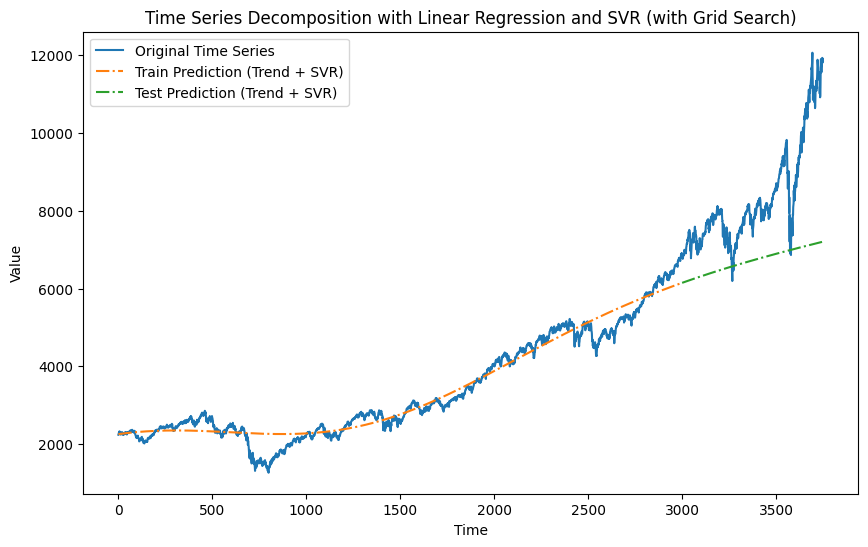

Best SVR parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.5}
Best cross-validation score: -468.2747443513649
Stock W5000 is being loaded...
Mean Absolute Error on Test Set: 3325.4557121098137


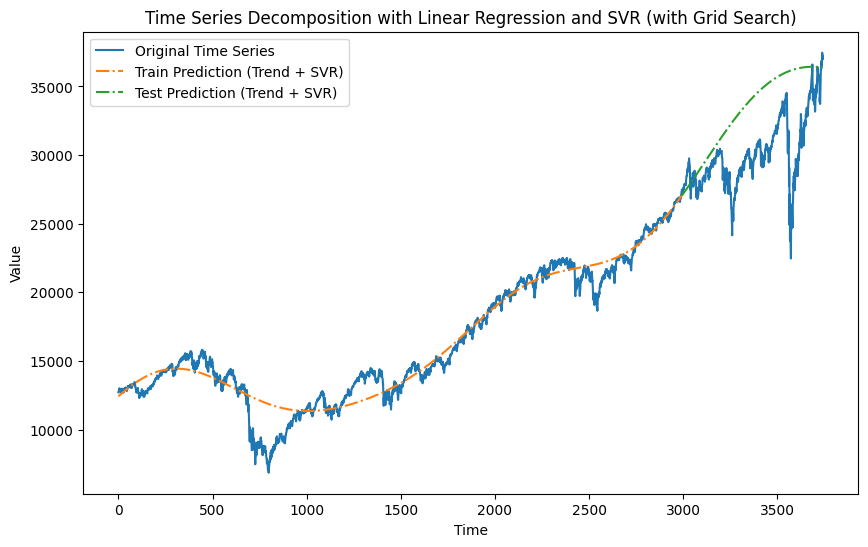

Best SVR parameters: {'C': 1000, 'epsilon': 0.1, 'gamma': 'scale'}
Best cross-validation score: -2155.4186451841488
Stock XLK is being loaded...
Mean Absolute Error on Test Set: 13.887980046016931


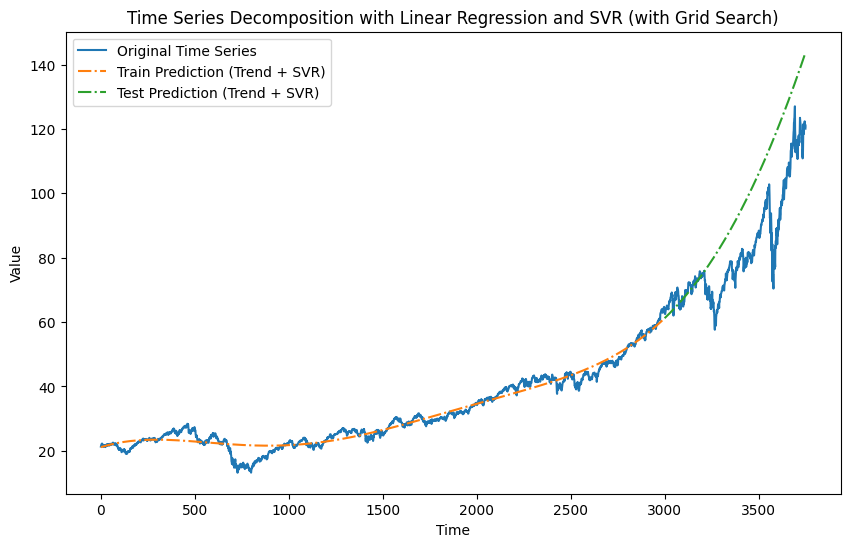

Best SVR parameters: {'C': 2000, 'epsilon': 0.01, 'gamma': 0.1}
Best cross-validation score: -3.1608251875330318
Stock GSPC is being loaded...
Mean Absolute Error on Test Set: 278.12598886435956


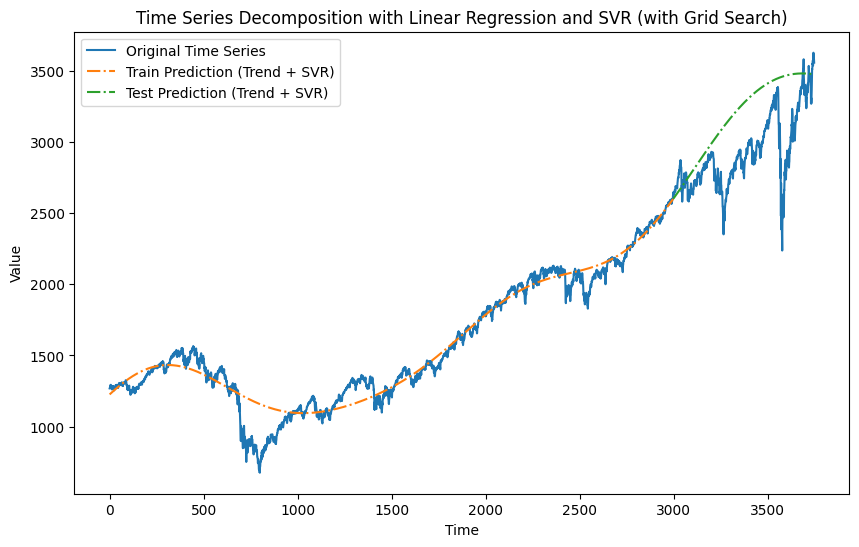

Best SVR parameters: {'C': 100, 'epsilon': 0.2, 'gamma': 'scale'}
Best cross-validation score: -199.7156986775773
Stock DJI is being loaded...
Mean Absolute Error on Test Set: 2543.846381043844


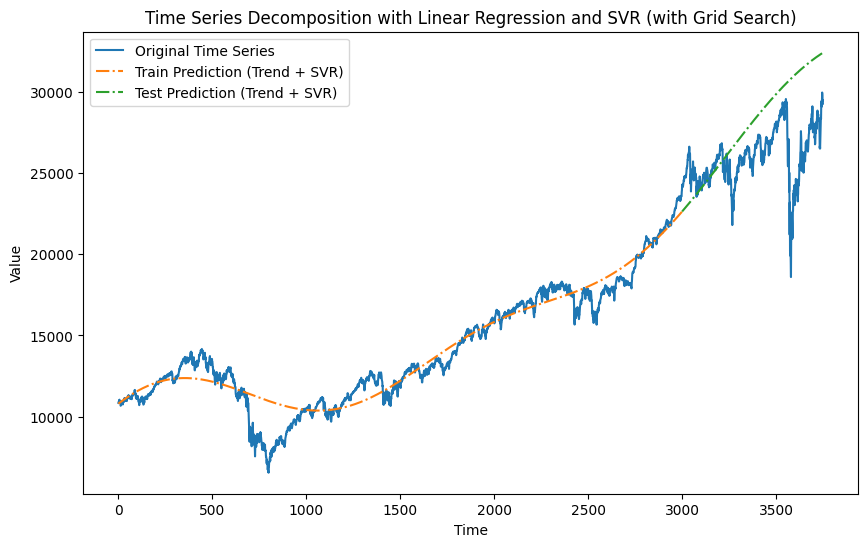

Best SVR parameters: {'C': 1000, 'epsilon': 0.2, 'gamma': 0.5}
Best cross-validation score: -1781.2872733354968


In [18]:
for i in range(len(diff_time_series)):
#     hyperparameter_c = best_svr[i][0]
#     hyperparameter_k = best_svr[i][1]
#     hyperparameter_gamma = best_svr[i][2]
    fit_svr_with_grid_search(time_series[i],i)

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def do_freq_analysis(time_series, index, log_trans):
    # Sampling frequency (assuming a fixed value, change if needed)
    fs = 1000  # Sampling frequency in Hz
    t = np.arange(0, len(time_series) / fs, 1/fs)  # Time vector based on the length of time_series

    # Perform Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(time_series)
    fft_magnitude = np.abs(fft_result)  # Magnitude of the FFT
    fft_freq = np.fft.fftfreq(len(time_series), 1/fs)  # Frequency axis

    # Plotting the original time series
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(t, time_series)
    plt.title(f'Time Series Signal {stock_index[index]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()

    # Plotting the frequency domain representation
    plt.subplot(1, 2, 2)
    # Only plot positive frequencies
    pos_indices = fft_freq > 0
    freq_to_plot = fft_freq[pos_indices]
    magnitude_to_plot = fft_magnitude[pos_indices]

    if log_trans:
        # Apply log transformation to the magnitude
        magnitude_to_plot = np.log1p(magnitude_to_plot)  # log(1 + magnitude) to avoid log(0)

    plt.plot(freq_to_plot, magnitude_to_plot)
    plt.title(f'Frequency Domain (FFT) {stock_index[index]}' + (' (Log Transformed)' if log_trans else ''))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude' + (' (Log Scale)' if log_trans else ''))
    plt.grid()

    plt.tight_layout()
    plt.show()

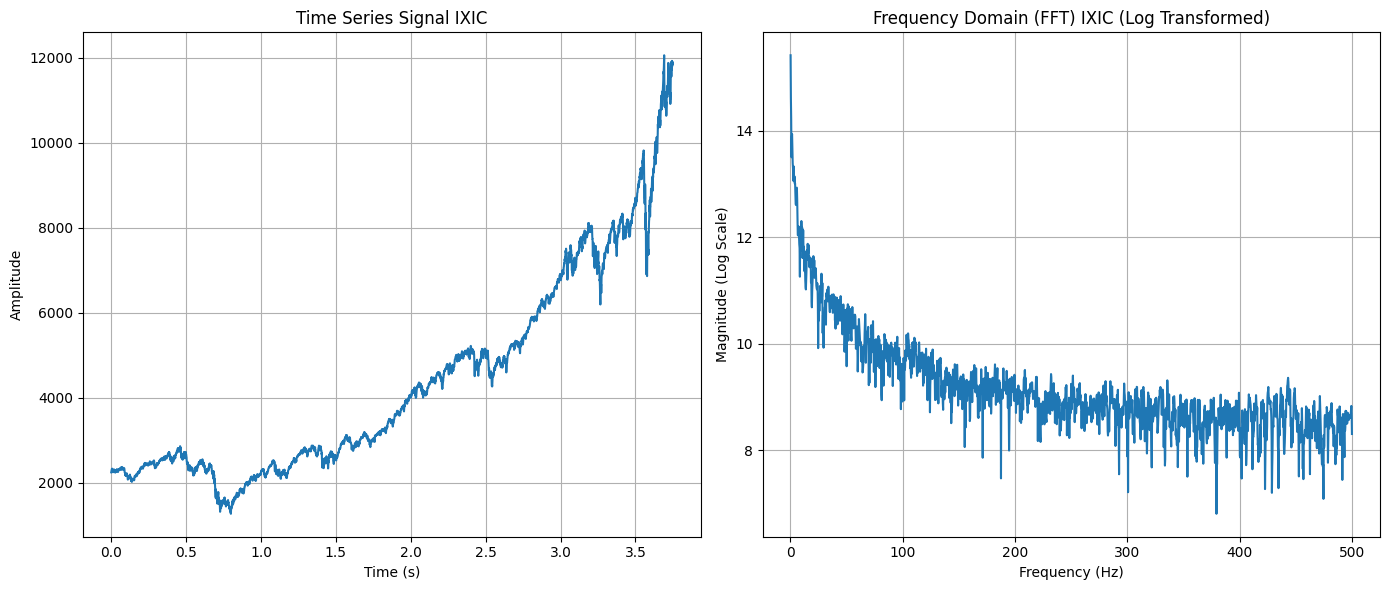

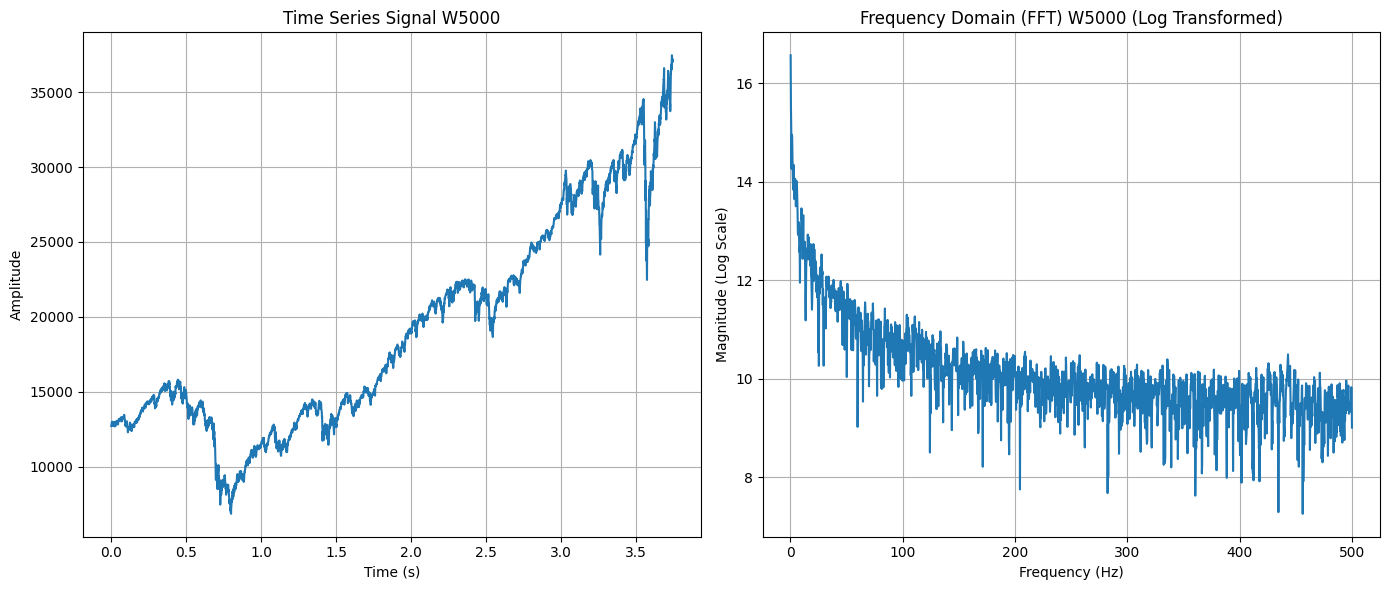

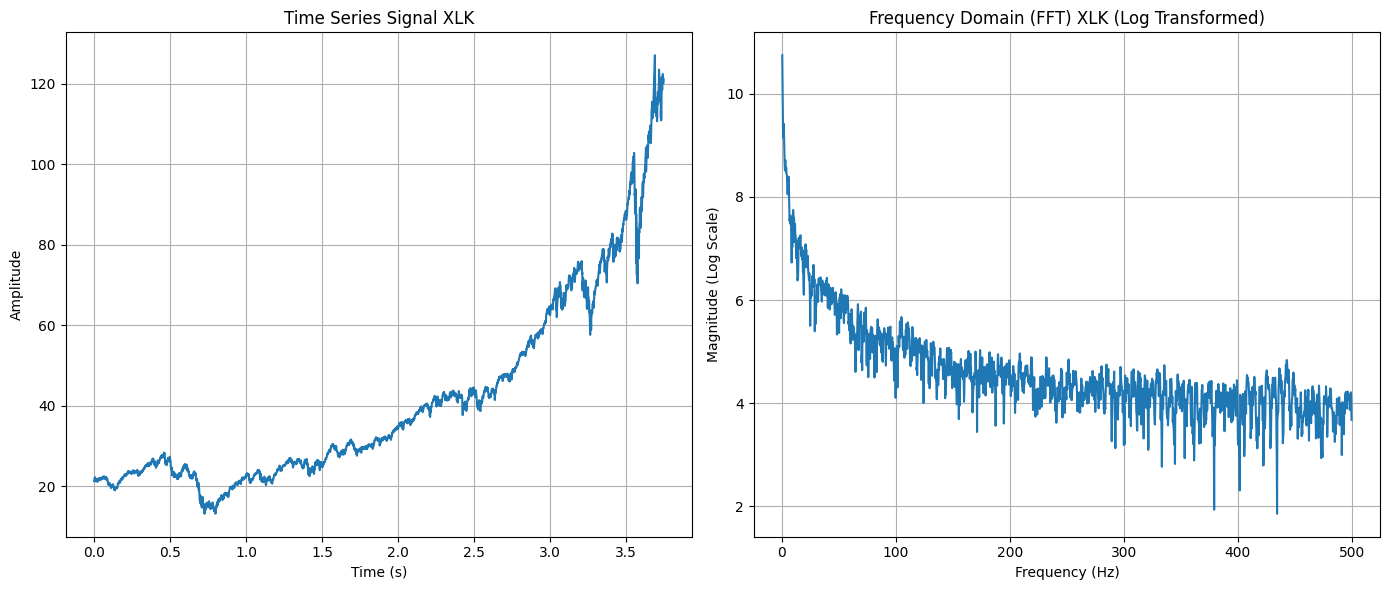

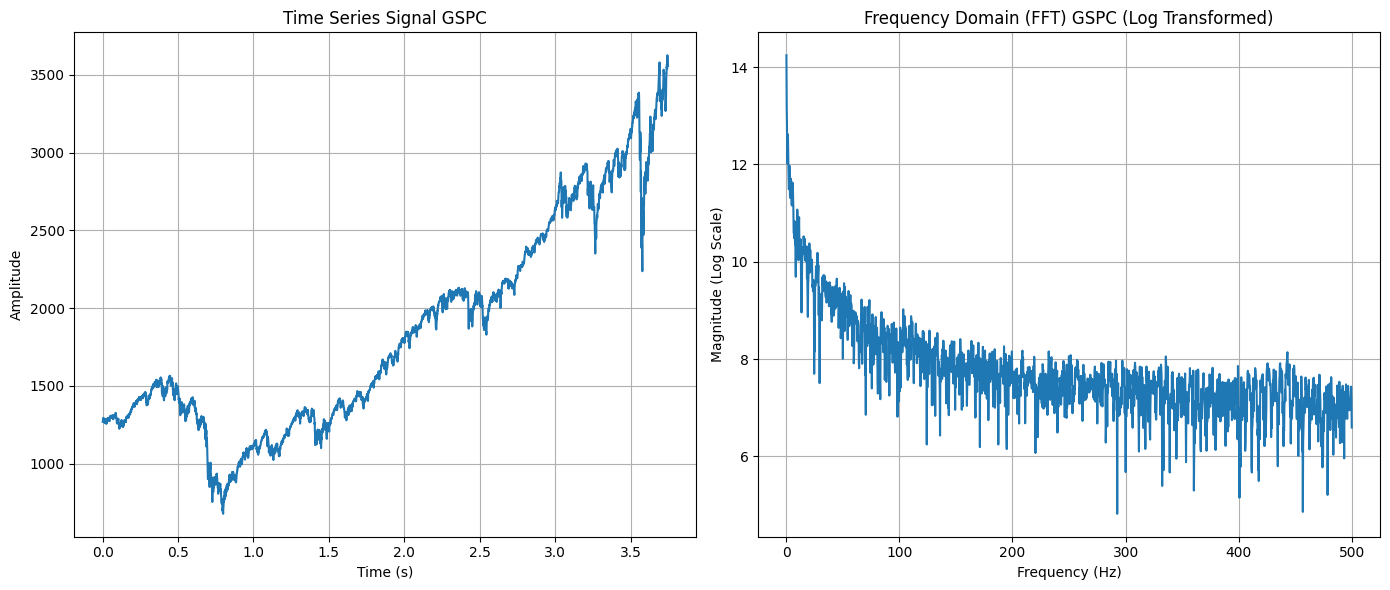

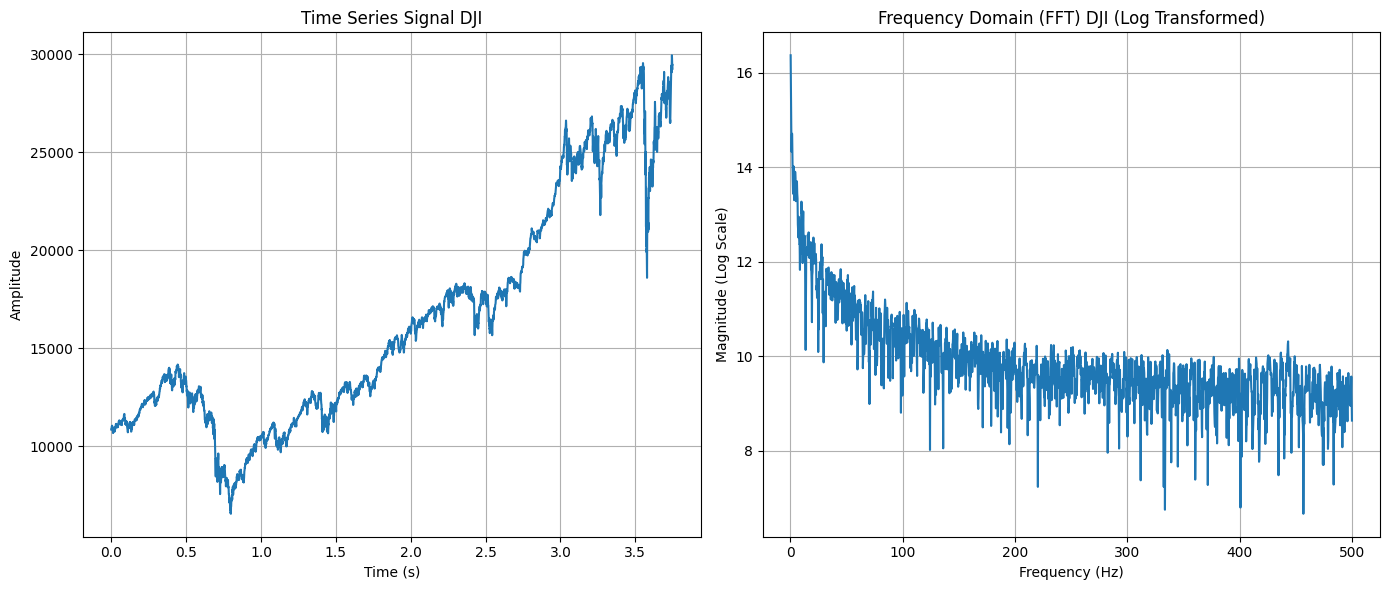

In [20]:
for i in range(len(diff_time_series)):
    do_freq_analysis(time_series[i], i,True)

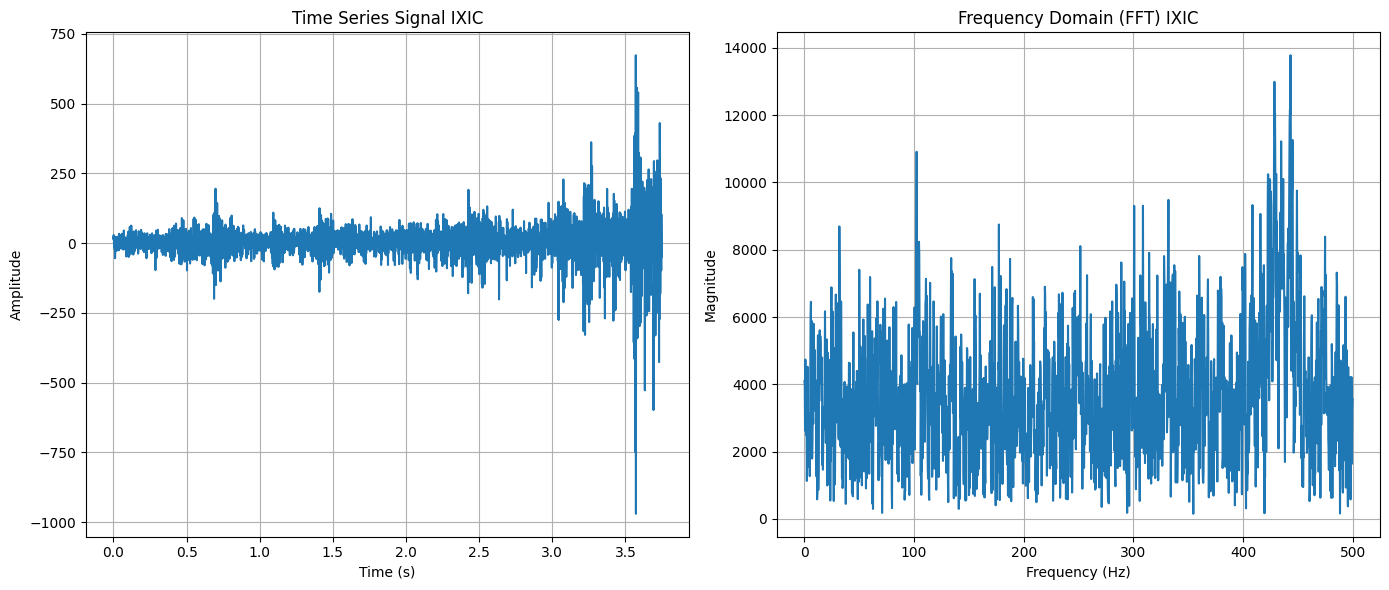

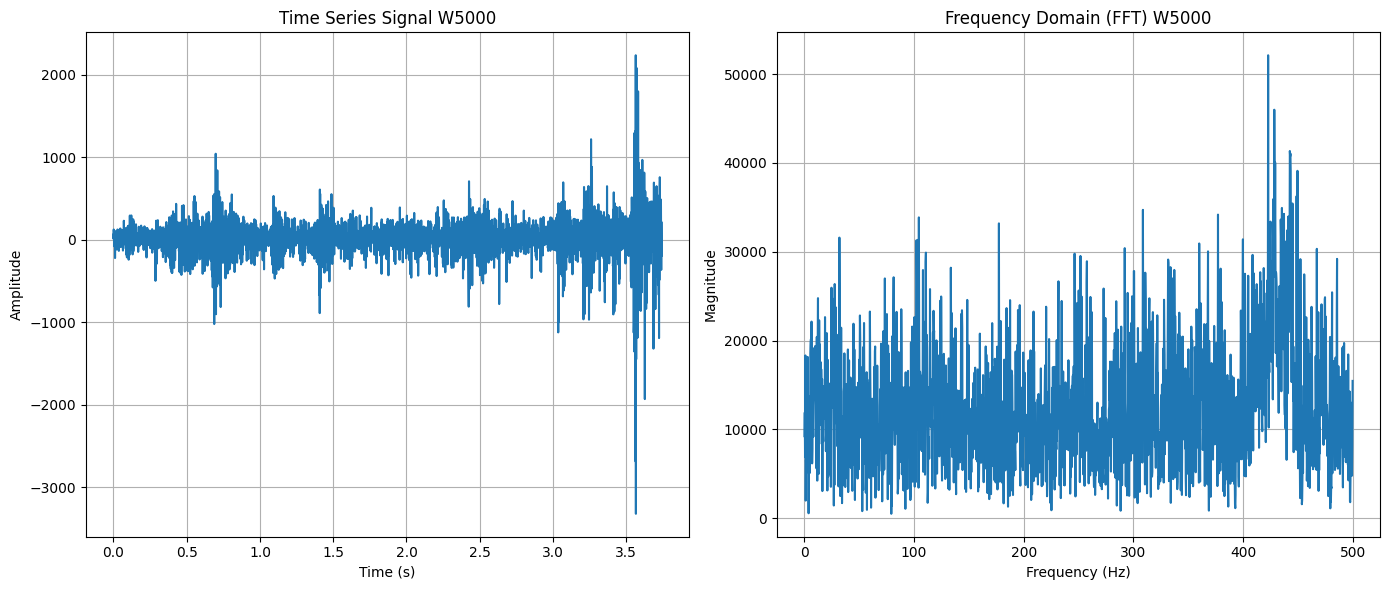

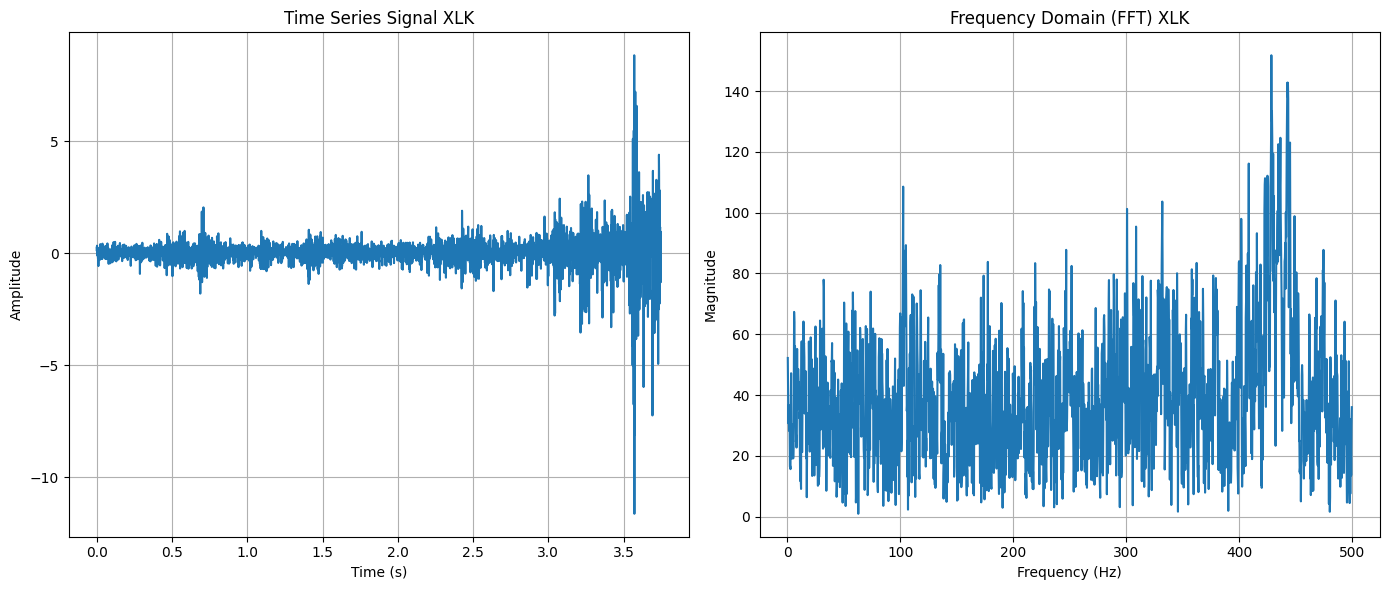

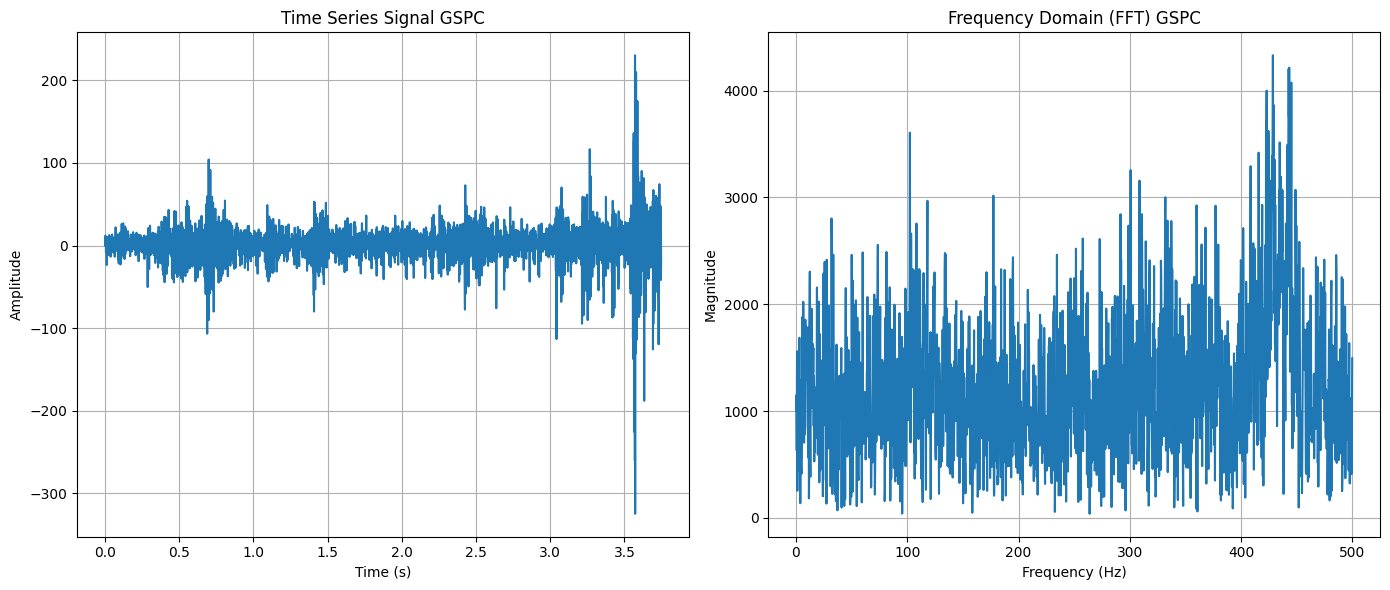

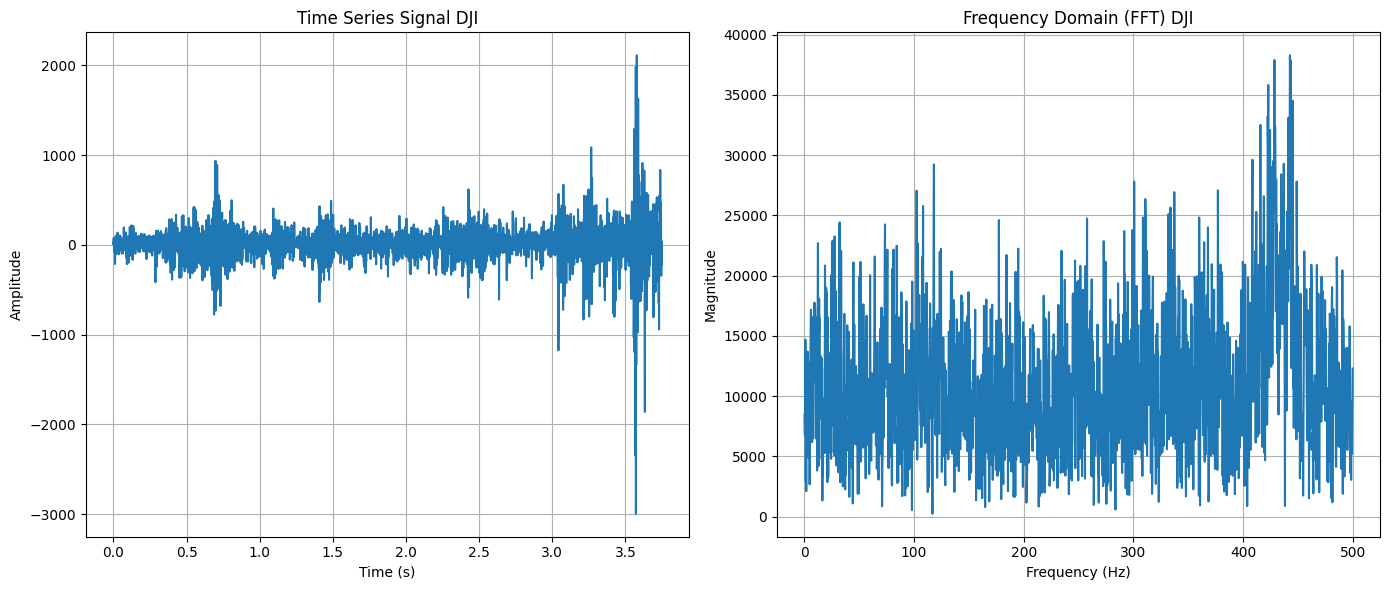

In [21]:
for i in range(len(diff_time_series)):
    do_freq_analysis(diff_time_series[i], i,False)